In [1]:
# !curl 'https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD' -o accidents.csv

In [2]:
# !sudo apt-get update
# !sudo apt-get install python3-rtree
# !sudo pip3 install -U geopandas descartes pandas matplotlib
# !sudo pip3 install -U shapely

In [3]:
# Render our plots inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import pandas as pd
import geopandas as gpd

df = pd.read_csv("accidents.csv", low_memory=False, dtype='object')
df['DATETIME'] = df.DATE + ' ' + df.TIME
df['DATETIME'] = pd.to_datetime(df['DATETIME'], format="%m/%d/%Y %H:%M")

In [5]:
# !rm accidents.csv

In [6]:
df.rename(
    {
    "ZIP CODE" : 'ZIPCODE',
    "NUMBER OF PERSONS INJURED": "PERSONS_INJURED",
    "NUMBER OF PERSONS KILLED": "PERSONS_KILLED",
    "NUMBER OF PEDESTRIANS INJURED": "PEDESTRIANS_INJURED",
    "NUMBER OF PEDESTRIANS KILLED": "PEDESTRIANS_KILLED",
    'NUMBER OF MOTORIST INJURED': 'MOTORISTS_INJURED',
    'NUMBER OF MOTORIST KILLED': 'MOTORISTS_KILLED', 
    'NUMBER OF CYCLIST INJURED': 'CYCLISTS_INJURED', 
    'NUMBER OF CYCLIST KILLED': 'CYCLISTS_KILLED',
    'CONTRIBUTING FACTOR VEHICLE 1': 'CAUSE_VEHICLE_1',
    'CONTRIBUTING FACTOR VEHICLE 2': 'CAUSE_VEHICLE_2',
    'CONTRIBUTING FACTOR VEHICLE 3': 'CAUSE_VEHICLE_3',
    'CONTRIBUTING FACTOR VEHICLE 4': 'CAUSE_VEHICLE_4',
    'CONTRIBUTING FACTOR VEHICLE 5': 'CAUSE_VEHICLE_5',
    'VEHICLE TYPE CODE 1': 'TYPE_VEHICLE_1',
    'VEHICLE TYPE CODE 2': 'TYPE_VEHICLE_2',
    'VEHICLE TYPE CODE 3': 'TYPE_VEHICLE_3',
    'VEHICLE TYPE CODE 4': 'TYPE_VEHICLE_4',
    'VEHICLE TYPE CODE 5': 'TYPE_VEHICLE_5',
    },
    axis = 'columns',
    inplace = True
)

In [7]:
cols = df.columns
cols = cols.map(lambda x: x.replace(' ', '_'))
df.columns = cols

In [8]:
cols = [
    'UNIQUE_KEY',
    'DATETIME',
    'BOROUGH',
    'ZIPCODE',
    'LATITUDE',
    'LONGITUDE',
    'LOCATION',
    'ON_STREET_NAME',
    'CROSS_STREET_NAME',
    'OFF_STREET_NAME',
    'PERSONS_INJURED',
    'PERSONS_KILLED',
    'PEDESTRIANS_INJURED',
    'PEDESTRIANS_KILLED',
    'CYCLISTS_INJURED',
    'CYCLISTS_KILLED',
    'MOTORISTS_INJURED',
    'MOTORISTS_KILLED',
    'CAUSE_VEHICLE_1',
    'CAUSE_VEHICLE_2',
    'CAUSE_VEHICLE_3',
    'CAUSE_VEHICLE_4',
    'CAUSE_VEHICLE_5',
    'TYPE_VEHICLE_1',
    'TYPE_VEHICLE_2',
    'TYPE_VEHICLE_3',
    'TYPE_VEHICLE_4',
    'TYPE_VEHICLE_5',
]

df = df[cols].copy()

In [9]:
df.dtypes

UNIQUE_KEY                     object
DATETIME               datetime64[ns]
BOROUGH                        object
ZIPCODE                        object
LATITUDE                       object
LONGITUDE                      object
LOCATION                       object
ON_STREET_NAME                 object
CROSS_STREET_NAME              object
OFF_STREET_NAME                object
PERSONS_INJURED                object
PERSONS_KILLED                 object
PEDESTRIANS_INJURED            object
PEDESTRIANS_KILLED             object
CYCLISTS_INJURED               object
CYCLISTS_KILLED                object
MOTORISTS_INJURED              object
MOTORISTS_KILLED               object
CAUSE_VEHICLE_1                object
CAUSE_VEHICLE_2                object
CAUSE_VEHICLE_3                object
CAUSE_VEHICLE_4                object
CAUSE_VEHICLE_5                object
TYPE_VEHICLE_1                 object
TYPE_VEHICLE_2                 object
TYPE_VEHICLE_3                 object
TYPE_VEHICLE

## Analysis of Data Types

### Datetime

In [10]:
# df['DATETIME'] = df.DATE + ' ' + df.TIME
# df.DATETIME = pd.to_datetime(df.DATETIME, format="%m/%d/%Y %H:%M")
#df.TIME = pd.to_datetime(df.TIME, format="%H:%M")
#df.DATE = pd.to_datetime(df.DATE, format="%m/%d/%Y")

In [11]:
# df['DATETIME'].hist(bins=7*12, figsize=(15,10))

In [12]:
# df.drop( ['DATE','TIME'], axis='columns', inplace=True)

### Borough

In [13]:
df['BOROUGH'] = pd.Categorical(df.BOROUGH)

In [14]:
df['BOROUGH'].value_counts()

BROOKLYN         331881
QUEENS           283986
MANHATTAN        259235
BRONX            148078
STATEN ISLAND     47404
Name: BOROUGH, dtype: int64

In [15]:
sum(~df['BOROUGH'].isnull())

1070584

In [16]:
sum(df['BOROUGH'].isnull())

460772

### Zip Code

In [17]:
df['ZIPCODE'] = pd.Categorical(df['ZIPCODE'])

In [18]:
sum(df['ZIPCODE'].isnull())

460954

### Longitute and Latitude

In [19]:
# We will get back to these columns with geo-shapefiles

In [20]:
df.LATITUDE = pd.to_numeric(df.LATITUDE)
df.LONGITUDE  = pd.to_numeric(df.LONGITUDE)

In [21]:
sum(df['LATITUDE'].isnull() | df['LONGITUDE'].isnull())

190207

In [22]:
df['LATITUDE'].fillna(0.0, inplace=True)
df['LONGITUDE'].fillna(0.0, inplace=True)
df.LOCATION = '(' + df.LATITUDE.astype(float).astype(str) + ', ' + df.LONGITUDE.astype(float).astype(str) + ')'

In [23]:
# This is just lon/lat combined
# df.drop( ['LOCATION'], axis='columns', inplace=True)

In [24]:
df.dtypes

UNIQUE_KEY                     object
DATETIME               datetime64[ns]
BOROUGH                      category
ZIPCODE                      category
LATITUDE                      float64
LONGITUDE                     float64
LOCATION                       object
ON_STREET_NAME                 object
CROSS_STREET_NAME              object
OFF_STREET_NAME                object
PERSONS_INJURED                object
PERSONS_KILLED                 object
PEDESTRIANS_INJURED            object
PEDESTRIANS_KILLED             object
CYCLISTS_INJURED               object
CYCLISTS_KILLED                object
MOTORISTS_INJURED              object
MOTORISTS_KILLED               object
CAUSE_VEHICLE_1                object
CAUSE_VEHICLE_2                object
CAUSE_VEHICLE_3                object
CAUSE_VEHICLE_4                object
CAUSE_VEHICLE_5                object
TYPE_VEHICLE_1                 object
TYPE_VEHICLE_2                 object
TYPE_VEHICLE_3                 object
TYPE_VEHICLE

In [25]:
df['UNIQUE_KEY'] = pd.to_numeric(df['UNIQUE_KEY'], downcast='unsigned')

In [26]:
df['PERSONS_INJURED'].fillna(0, inplace=True)
df['PERSONS_INJURED'] = pd.to_numeric(df['PERSONS_INJURED'], downcast='unsigned')

In [27]:
df['PERSONS_KILLED'].fillna(0, inplace=True)
df['PERSONS_KILLED']  = pd.to_numeric(df['PERSONS_KILLED'], downcast='unsigned')

In [28]:
df['PEDESTRIANS_INJURED'].fillna(0, inplace=True)
df['PEDESTRIANS_INJURED'] = pd.to_numeric(df['PEDESTRIANS_INJURED'], downcast='unsigned')

In [29]:
df['PEDESTRIANS_KILLED'].fillna(0, inplace=True)
df['PEDESTRIANS_KILLED'] = pd.to_numeric(df['PEDESTRIANS_KILLED'], downcast='unsigned')

In [30]:
df['CYCLISTS_INJURED'].fillna(0, inplace=True)
df['CYCLISTS_INJURED'] = pd.to_numeric(df['CYCLISTS_INJURED'], downcast='unsigned')

In [31]:
df['CYCLISTS_KILLED'].fillna(0, inplace=True)
df['CYCLISTS_KILLED'] = pd.to_numeric(df['CYCLISTS_KILLED'], downcast='unsigned')

In [32]:
df['MOTORISTS_INJURED'].fillna(0, inplace=True)
df['MOTORISTS_INJURED'] = pd.to_numeric(df['MOTORISTS_INJURED'], downcast='unsigned')

In [33]:
df['MOTORISTS_KILLED'].fillna(0, inplace=True)
df['MOTORISTS_KILLED'] = pd.to_numeric(df['MOTORISTS_KILLED'], downcast='unsigned')

## Normalizing Causes and Types

In [34]:
df['CAUSE_VEHICLE_1'] = pd.Categorical(df['CAUSE_VEHICLE_1'].str.upper())
df['CAUSE_VEHICLE_2'] = pd.Categorical(df['CAUSE_VEHICLE_2'].str.upper())
df['CAUSE_VEHICLE_3'] = pd.Categorical(df['CAUSE_VEHICLE_3'].str.upper())
df['CAUSE_VEHICLE_4'] = pd.Categorical(df['CAUSE_VEHICLE_4'].str.upper())
df['CAUSE_VEHICLE_5'] = pd.Categorical(df['CAUSE_VEHICLE_5'].str.upper())
df['TYPE_VEHICLE_1'] = pd.Categorical(df['TYPE_VEHICLE_1'].str.upper())
df['TYPE_VEHICLE_2'] = pd.Categorical(df['TYPE_VEHICLE_2'].str.upper())
df['TYPE_VEHICLE_3'] = pd.Categorical(df['TYPE_VEHICLE_3'].str.upper())
df['TYPE_VEHICLE_4'] = pd.Categorical(df['TYPE_VEHICLE_4'].str.upper())
df['TYPE_VEHICLE_5'] = pd.Categorical(df['TYPE_VEHICLE_5'].str.upper())


In [35]:
import numpy as np
df1 = df[['UNIQUE_KEY', 'CAUSE_VEHICLE_1', 'TYPE_VEHICLE_1']].copy()
df1['VEHICLE'] = 1
df1.columns = ['UNIQUE_KEY', 'CAUSE', 'VEHICLE_TYPE', 'VEHICLE']

df2 = df[['UNIQUE_KEY', 'CAUSE_VEHICLE_2', 'TYPE_VEHICLE_2']].copy()
df2['VEHICLE'] = 2
df2.columns = ['UNIQUE_KEY', 'CAUSE', 'VEHICLE_TYPE', 'VEHICLE']

df3 = df[['UNIQUE_KEY', 'CAUSE_VEHICLE_3', 'TYPE_VEHICLE_3']].copy()
df3['VEHICLE'] = 3
df3.columns = ['UNIQUE_KEY', 'CAUSE', 'VEHICLE_TYPE', 'VEHICLE']

df4 = df[['UNIQUE_KEY', 'CAUSE_VEHICLE_4', 'TYPE_VEHICLE_4']].copy()
df4['VEHICLE'] = 4
df4.columns = ['UNIQUE_KEY', 'CAUSE', 'VEHICLE_TYPE', 'VEHICLE']

df5 = df[['UNIQUE_KEY', 'CAUSE_VEHICLE_5', 'TYPE_VEHICLE_5']].copy()
df5['VEHICLE'] = 5
df5.columns = ['UNIQUE_KEY', 'CAUSE', 'VEHICLE_TYPE', 'VEHICLE']

ct_df = pd.concat( [df1, df2, df3, df4, df5] ).set_index('UNIQUE_KEY').sort_values(['UNIQUE_KEY','VEHICLE']).dropna()

In [36]:
ct_df.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 2895106 entries, 22 to 4168563
Data columns (total 3 columns):
CAUSE           object
VEHICLE_TYPE    object
VEHICLE         int64
dtypes: int64(1), object(2)
memory usage: 88.4+ MB


In [37]:
ct_df.memory_usage()

Index           23160848
CAUSE           23160848
VEHICLE_TYPE    23160848
VEHICLE         23160848
dtype: int64

In [38]:
ct_df['CAUSE'] = pd.Categorical(ct_df['CAUSE'])
ct_df['VEHICLE_TYPE'] = pd.Categorical(ct_df['VEHICLE_TYPE'])
# ct_df['VEHICLE'] = pd.Categorical(ct_df['VEHICLE'])

In [39]:
ct_df.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 2895106 entries, 22 to 4168563
Data columns (total 3 columns):
CAUSE           category
VEHICLE_TYPE    category
VEHICLE         int64
dtypes: category(2), int64(1)
memory usage: 52.5 MB


In [40]:
ct_df.memory_usage()

Index           23160848
CAUSE            2898138
VEHICLE_TYPE     5815844
VEHICLE         23160848
dtype: int64

In [41]:
df.drop([
    'CAUSE_VEHICLE_1', 'CAUSE_VEHICLE_2', 'CAUSE_VEHICLE_3', 'CAUSE_VEHICLE_4',
    'CAUSE_VEHICLE_5', 'TYPE_VEHICLE_1', 'TYPE_VEHICLE_2', 'TYPE_VEHICLE_3',
    'TYPE_VEHICLE_4', 'TYPE_VEHICLE_5'
], axis = 'columns', inplace=True)

## Detecting Inconsistencies

In [42]:
len(df[ df.PEDESTRIANS_INJURED + df.CYCLISTS_INJURED + df.MOTORISTS_INJURED != df.PERSONS_INJURED])

387

In [43]:
len(df[ df.PEDESTRIANS_KILLED + df.CYCLISTS_KILLED + df.MOTORISTS_KILLED != df.PERSONS_KILLED])

8

In [44]:
dd1 = ct_df[['VEHICLE']].groupby('UNIQUE_KEY').count()
dd2 = ct_df[['VEHICLE']].groupby('UNIQUE_KEY').max()

j = dd1.merge(dd2, left_index=True, right_index=True)
j.columns = ['cnt', 'max']
j.query("cnt != max")

cnt  max
UNIQUE_KEY          
3184121       1    2
3194318       1    2
3202121       1    2
3214569       1    2

In [45]:
len(df[df.UNIQUE_KEY.isin( set(df.UNIQUE_KEY) -set(ct_df.index.values) ) ])

7287

## Lon/lat analysis, plus zipcode/borough

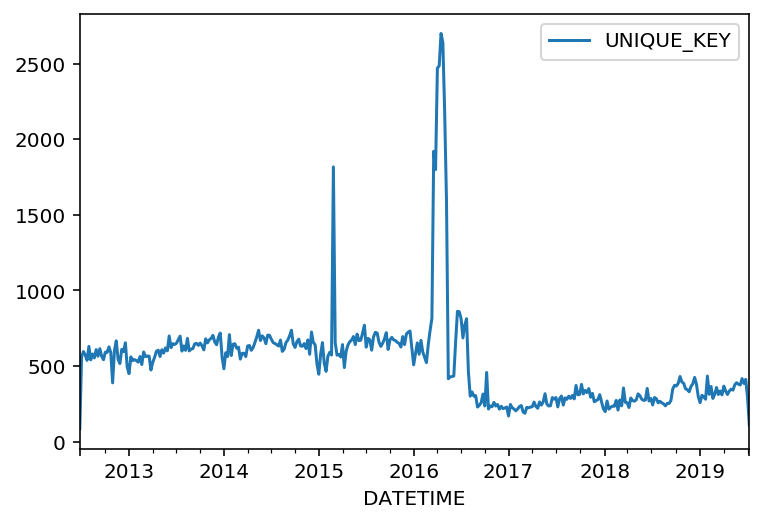

In [46]:
# Check if there is a temporal pattern in the errors
# The spikes are visible for the period of Mar-May 2016
df[ (df.LATITUDE==0.0) & (df.LONGITUDE==0.0) ].pivot_table(
    index='DATETIME',
    values='UNIQUE_KEY',
    aggfunc='count'
).resample('1W').sum().plot()

In [47]:
# No cases where BOROUGH is null but zipcode is not
df[ df.BOROUGH.isnull() & ~df.ZIPCODE.isnull() ]

Empty DataFrame
Columns: [UNIQUE_KEY, DATETIME, BOROUGH, ZIPCODE, LATITUDE, LONGITUDE, LOCATION, ON_STREET_NAME, CROSS_STREET_NAME, OFF_STREET_NAME, PERSONS_INJURED, PERSONS_KILLED, PEDESTRIANS_INJURED, PEDESTRIANS_KILLED, CYCLISTS_INJURED, CYCLISTS_KILLED, MOTORISTS_INJURED, MOTORISTS_KILLED]
Index: []

In [48]:
# Small number of cases where the borough is missing
len(df[ ~df.BOROUGH.isnull() & df.ZIPCODE.isnull() ])

182

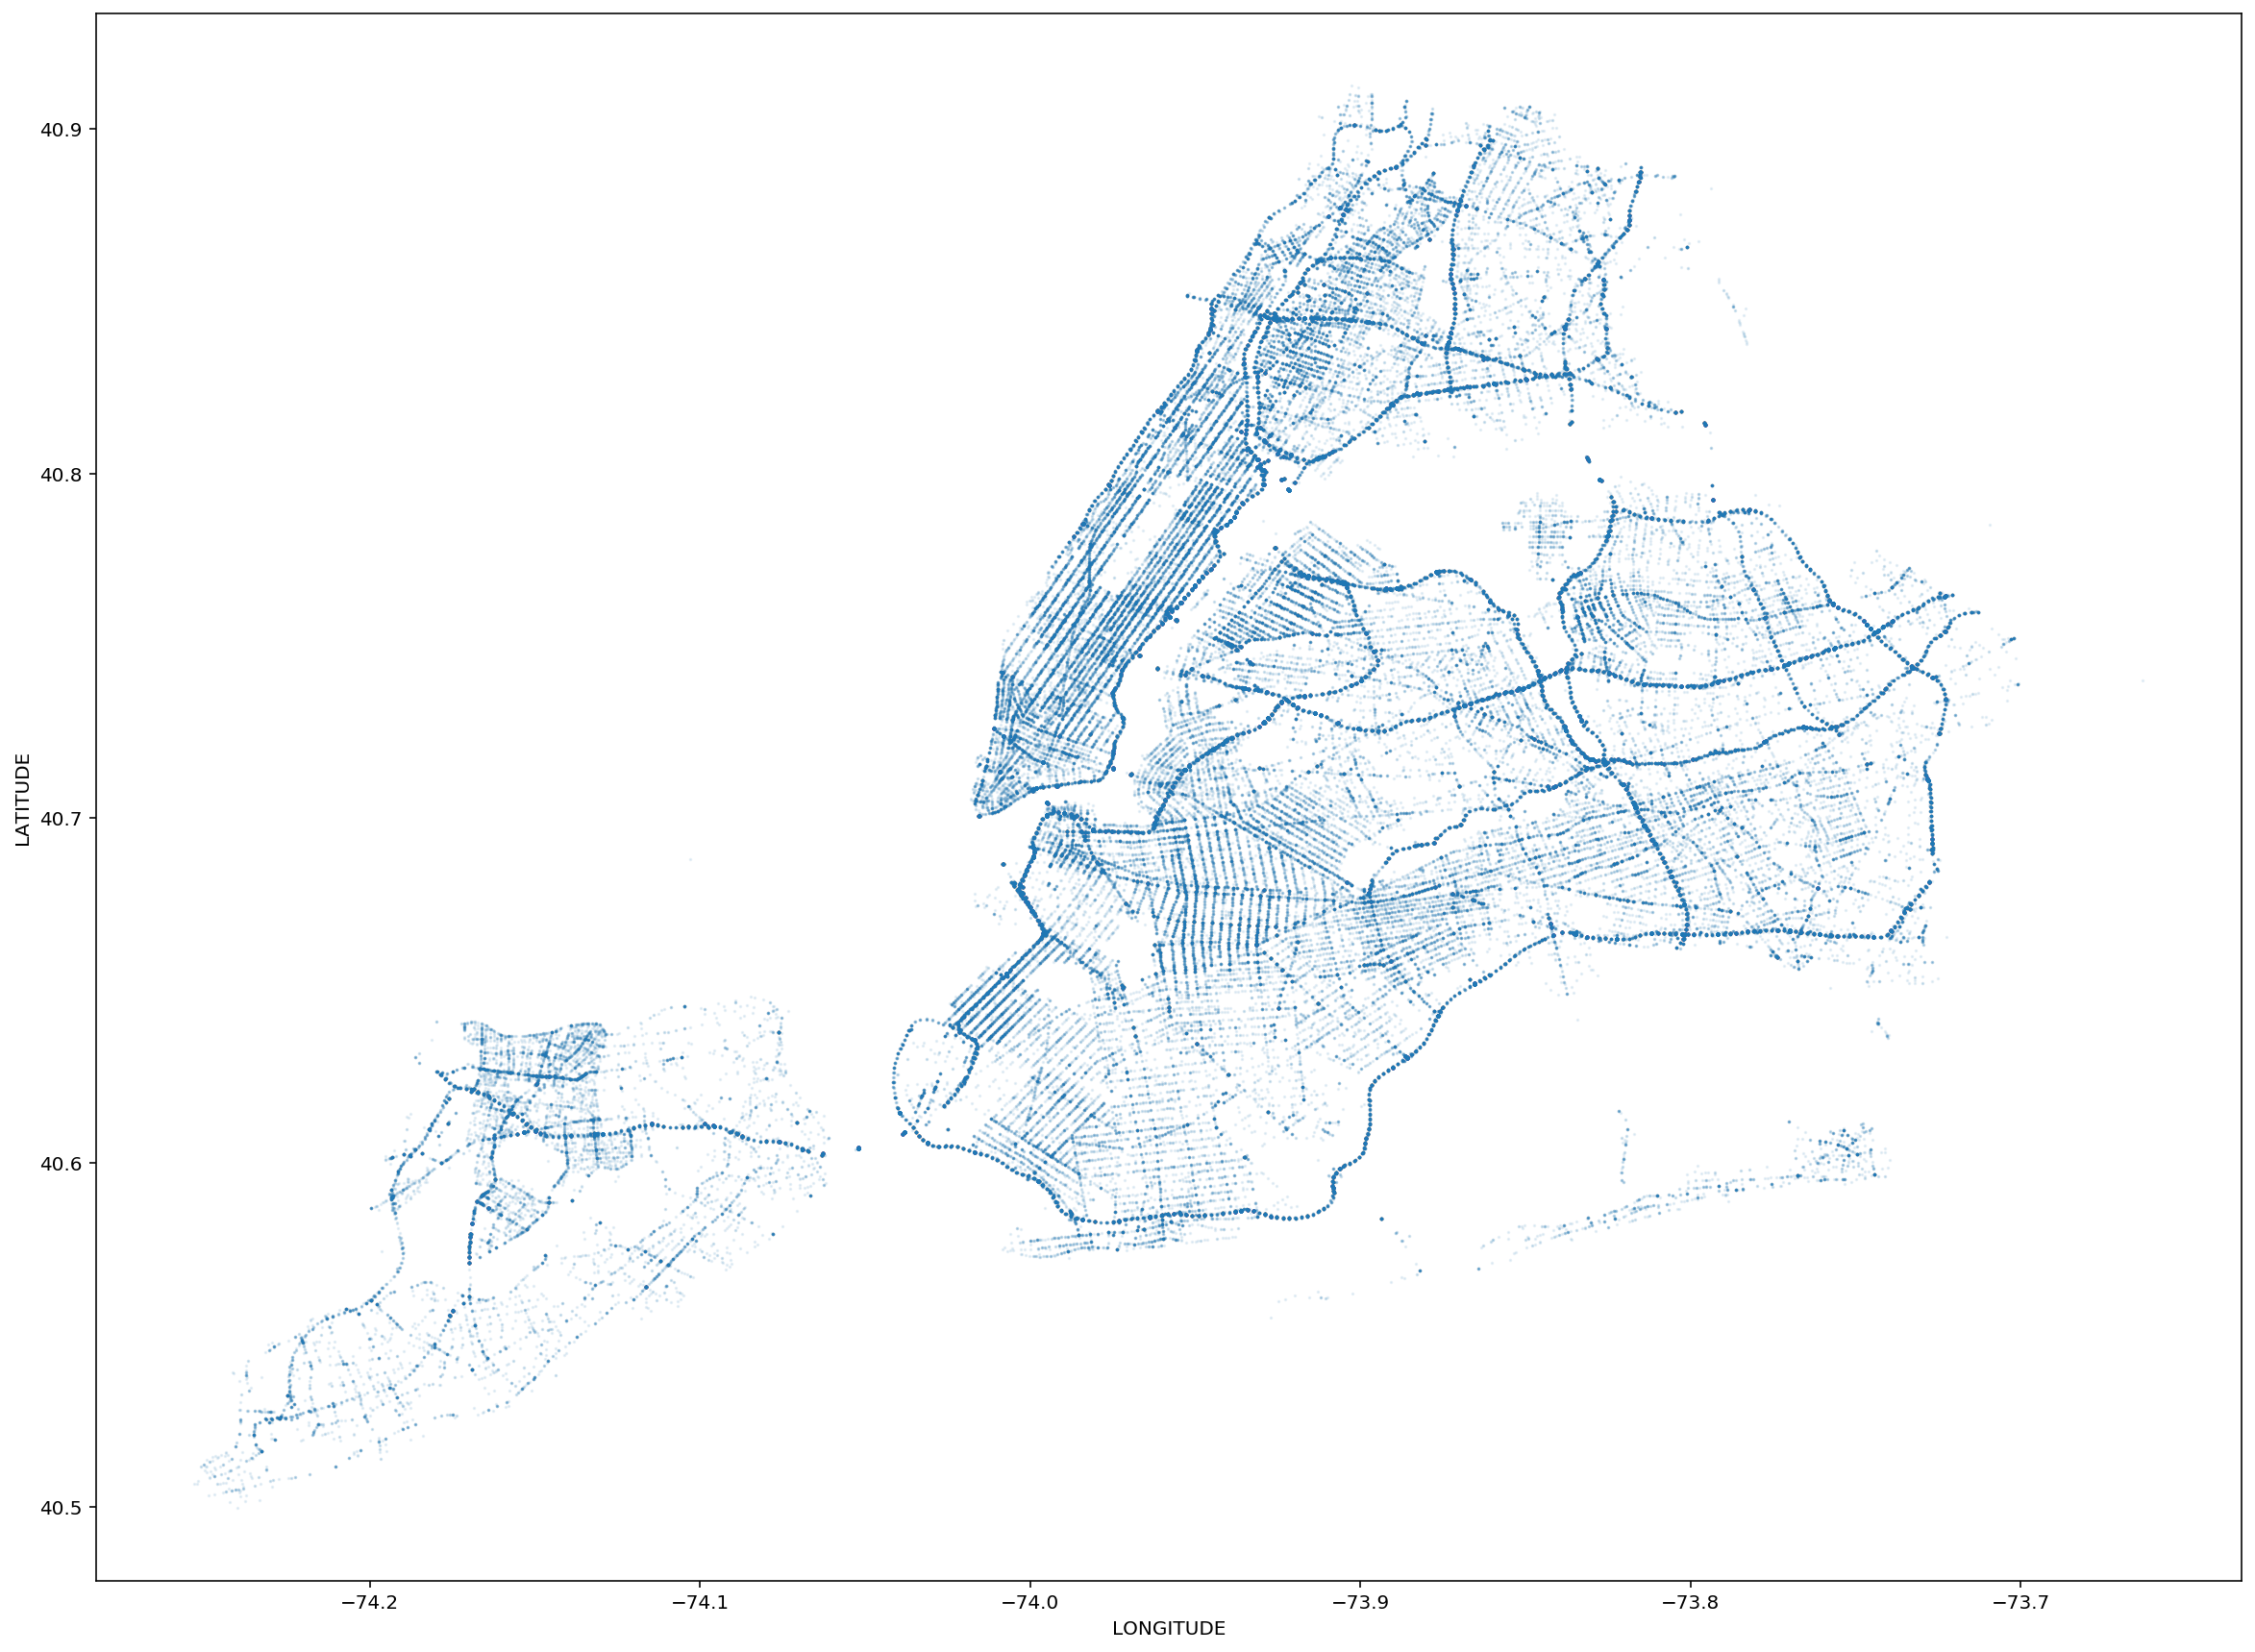

In [49]:
# A map of all the accidents where the BOROUGH is NULL
# Not clear why, but there is a strong bias for highway collissions
# not to have the BOROUGH set. We will fix that later on by using
# the BORO_NAME attribute from the spatial join with the NYC shapefile

# The 'mask' sets rough bound box limits for NYC
mask = (df.LATITUDE > 40) & (df.LATITUDE < 41) & (df.LONGITUDE < -72) & (df.LONGITUDE > -74.5)

df[ df.BOROUGH.isnull() & mask ].plot(
    kind='scatter',
    x='LONGITUDE',
    y='LATITUDE',
    figsize=(20, 15),
    s=0.5,
    alpha=0.1)

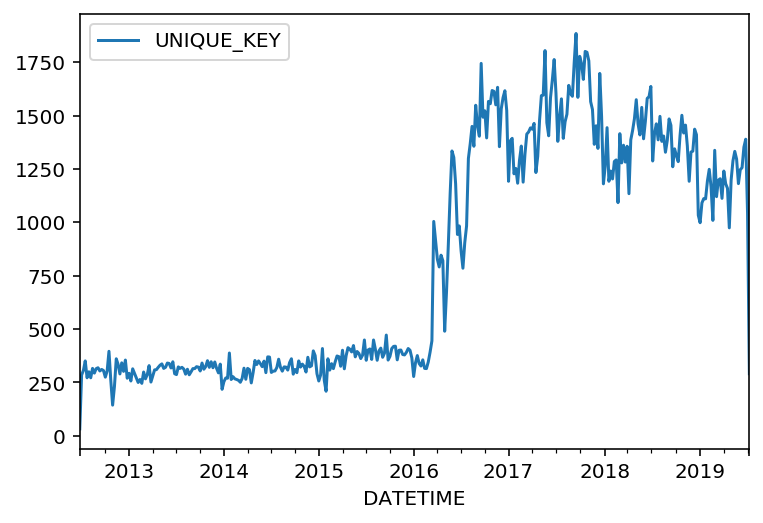

In [50]:
# Check if there is a temporal pattern in the errors

df[ df.BOROUGH.isnull() & mask ].pivot_table(
    index='DATETIME',
    values='UNIQUE_KEY',
    aggfunc='count'
).resample('1W').sum().plot()

## Augment Borough and Zipcode using Shapefiles

In [94]:
# We start by converting the LON/LAT attributes into Shapely "geo-points"
# and convert the resut into a geodataframe so that we can do a spatial join 
from shapely.geometry import Point
df['Coordinates'] = list(zip(df.LONGITUDE, df.LATITUDE))
df['Coordinates'] = df['Coordinates'].apply(Point)
gdf = gpd.GeoDataFrame(df, geometry='Coordinates')

In [95]:
# We will now perform a spatial join with the NYC shapefile 
# to find the neighborhood for each accident, and also filter out
# automatically all the accidents that have incorrect coordinates
# and/or incorrect BOROUGH listed

In [96]:
shapefile_url = 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=Shapefile'
df_nyc = gpd.GeoDataFrame.from_file(shapefile_url)

In [97]:
df_nyc.crs

{'init': 'epsg:4326'}

In [98]:
%%time
# Match each accident with a neighborhood. 
# Takes ~ 1-2 mins to run
# This is done with inner join, we we will be losing data points
gdf.crs = df_nyc.crs
gdf = gpd.sjoin(df_nyc, gdf)


CPU times: user 1min 11s, sys: 1.1 s, total: 1min 12s
Wall time: 1min 12s


In [99]:
# We keep only boro_name and ntaname
todrop = [
    'boro_code', 'county_fip', 'ntacode', 'shape_area',
    'shape_leng', 'geometry', 'index_right'
]

gdf = gdf.drop(todrop, axis='columns')

# Rename the columns
gdf = gdf.rename({
    'boro_name': 'GEO_BOROUGH',
    'ntaname': 'GEO_NEIGHBORHOOD',
}, axis='columns')

In [100]:
gdf.columns.values

array(['GEO_BOROUGH', 'GEO_NEIGHBORHOOD', 'UNIQUE_KEY', 'DATETIME',
       'BOROUGH', 'ZIPCODE', 'LATITUDE', 'LONGITUDE', 'LOCATION',
       'ON_STREET_NAME', 'CROSS_STREET_NAME', 'OFF_STREET_NAME',
       'PERSONS_INJURED', 'PERSONS_KILLED', 'PEDESTRIANS_INJURED',
       'PEDESTRIANS_KILLED', 'CYCLISTS_INJURED', 'CYCLISTS_KILLED',
       'MOTORISTS_INJURED', 'MOTORISTS_KILLED'], dtype=object)

In [101]:
%%time
shapefile_zip = 'https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip'
df_zip = gpd.GeoDataFrame.from_file(shapefile_zip)
# Converting the df_zip from {'init': 'epsg:2263'} coordinate system
# to the same lon/lat system used by df_nyc
df_zip = df_zip.to_crs(df_nyc.crs)

# Creating the geodataframe using lon/lat coordinates
gdf['Coordinates'] = list(zip(gdf.LONGITUDE, gdf.LATITUDE))
gdf['Coordinates'] = gdf['Coordinates'].apply(Point)
gdf = gpd.GeoDataFrame(gdf, geometry='Coordinates')

# Spatial inner join, keeping 
gdf.crs = df_zip.crs
gdf = gpd.sjoin(gdf, df_zip)

todrop = [
    'BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE', 'COUNTY', 'ST_FIPS',
    'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN', 'Coordinates', 'index_right'
]
gdf = gdf.drop(todrop, axis='columns')
gdf = gdf.rename({'ZIPCODE_left': 'ZIPCODE', 'ZIPCODE_right': 'GEO_ZIPCODE'}, axis='columns')

CPU times: user 2min 8s, sys: 1.56 s, total: 2min 9s
Wall time: 2min 12s


In [102]:
gdf.columns.values

array(['GEO_BOROUGH', 'GEO_NEIGHBORHOOD', 'UNIQUE_KEY', 'DATETIME',
       'BOROUGH', 'ZIPCODE', 'LATITUDE', 'LONGITUDE', 'LOCATION',
       'ON_STREET_NAME', 'CROSS_STREET_NAME', 'OFF_STREET_NAME',
       'PERSONS_INJURED', 'PERSONS_KILLED', 'PEDESTRIANS_INJURED',
       'PEDESTRIANS_KILLED', 'CYCLISTS_INJURED', 'CYCLISTS_KILLED',
       'MOTORISTS_INJURED', 'MOTORISTS_KILLED', 'GEO_ZIPCODE'],
      dtype=object)

## Post-Augmentation Analysis of Inconsistencies

In [103]:
len(gdf)

1331885

In [104]:
not_matching = set(df['UNIQUE_KEY'].values) - set(gdf['UNIQUE_KEY'].values)

In [105]:
len(not_matching)

200336

In [106]:
# These are the entries that we could filter out with a simple mask
nm1 = df[ df['UNIQUE_KEY'].isin(not_matching) & ~mask ]
nm1.head()

UNIQUE_KEY            DATETIME        BOROUGH ZIPCODE  LATITUDE  \
6      4167828 2019-07-09 00:00:00  STATEN ISLAND   10309       0.0   
10     4167407 2019-07-09 00:00:00            NaN     NaN       0.0   
26     4167458 2019-07-09 10:00:00          BRONX   10461       0.0   
29     4166906 2019-07-09 10:00:00         QUEENS   11354       0.0   
38     4168329 2019-07-09 10:05:00            NaN     NaN       0.0   

    LONGITUDE    LOCATION                    ON_STREET_NAME  \
6         0.0  (0.0, 0.0)                               NaN   
10        0.0  (0.0, 0.0)  HENRY HUDSON PARKWAY RAMP          
26        0.0  (0.0, 0.0)  EASTCHESTER ROAD                   
29        0.0  (0.0, 0.0)  PRINCE STREET                      
38        0.0  (0.0, 0.0)  VERRAZANO BRIDGE LOWER             

     CROSS_STREET_NAME                           OFF_STREET_NAME  \
6                  NaN  2935      VETERANS ROAD WEST               
10                 NaN                                       NaN   
26      BASSETT AVENUE                                       NaN   
29  NORTHERN BOULEVARD                                       NaN   
38                 NaN                                       NaN   

    PERSONS_INJURED  PERSONS_KILLED  PEDESTRIANS_INJURED  PEDESTRIANS_KILLED  \
6                 0               0                    0                   0   
10                0               0                    0                   0   
26                0               0                    0                   0   
29                0               0                    0                   0   
38                0               0                    0                   0   

    CYCLISTS_INJURED  CYCLISTS_KILLED  MOTORISTS_INJURED  MOTORISTS_KILLED  \
6                  0                0                  0                 0   
10                 0                0                  0                 0   
26                 0                0                  0                 0   
29                 0                0                  0                 0   
38                 0                0                  0                 0   

    Coordinates  
6   POINT (0 0)  
10  POINT (0 0)  
26  POINT (0 0)  
29  POINT (0 0)  
38  POINT (0 0)

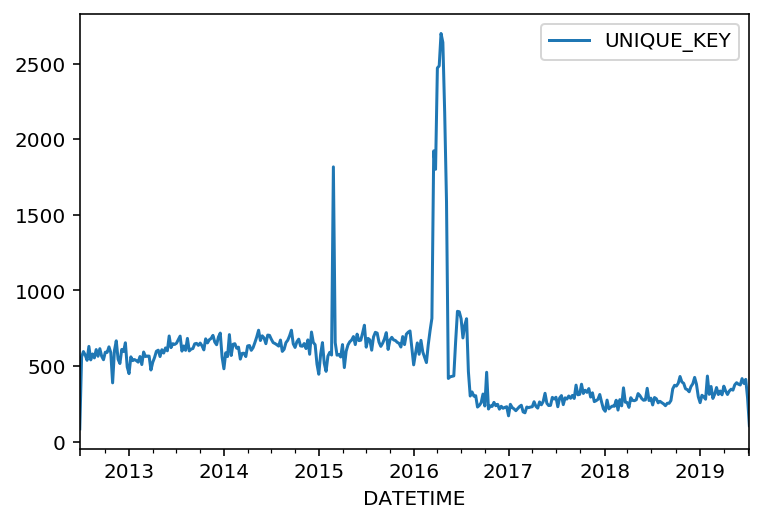

In [107]:
nm1.pivot_table(
    index='DATETIME',
    values='UNIQUE_KEY',
    aggfunc='count'
).resample('1W').sum().plot()

In [108]:
nm1.LOCATION.value_counts()

(0.0, 0.0)                          191212
(40.75837, -201.23706)                 105
(40.665226000000004, -32.768513)        16
(40.5606, -74.742)                       7
(41.12615, -73.71353)                    5
(40.556175, -47.209625)                  3
(41.061634000000005, -73.97066)          2
(41.12421, -73.71412)                    1
(42.64154, -79.00183)                    1
(41.91661, -79.61955)                    1
(40.854286, -201.35998999999998)         1
(34.783634, -86.76847)                   1
(41.258784999999996, -73.99024)          1
(30.78418, -89.13526999999999)           1
(42.107203999999996, -76.02163)          1
(43.344444, -76.2634)                    1
(41.34796, -73.96965)                    1
(42.318317, -73.755936)                  1
Name: LOCATION, dtype: int64

In [109]:
# These are the entries that are not matching with a neighborhood
# but are within the NYC boundaries.
nm2 = df[ df['UNIQUE_KEY'].isin(not_matching) & mask ]
nm2.head()

UNIQUE_KEY            DATETIME BOROUGH ZIPCODE   LATITUDE  LONGITUDE  \
1258     4165902 2019-07-07 16:30:00     NaN     NaN  40.727660  -73.92938   
1575     4165283 2019-07-06 12:10:00     NaN     NaN  40.845352  -73.92821   
2104     4165749 2019-07-05 14:30:00     NaN     NaN  40.851190  -73.95056   
2575     4164875 2019-07-04 14:40:00  QUEENS   11422  40.636787  -73.74057   
3696     4163958 2019-07-02 15:40:00  QUEENS   11385  40.712864  -73.90478   

                             LOCATION                    ON_STREET_NAME  \
1258   (40.72766, -73.92938000000001)  BROOKLYN QUEENS EXPRESSWAY         
1575  (40.845352, -73.92820999999999)  CROSS BRONX EXPY                   
2104            (40.85119, -73.95056)  CROSS BRONX EXPY                   
2575  (40.636787, -73.74056999999999)  ROCKAWAY BOULEVARD                 
3696           (40.712864, -73.90478)  METROPOLITAN AVENUE                

     CROSS_STREET_NAME OFF_STREET_NAME  PERSONS_INJURED  PERSONS_KILLED  \
1258               NaN             NaN                0               0   
1575               NaN             NaN                2               0   
2104               NaN             NaN                0               0   
2575          1 STREET             NaN                0               0   
3696      ELIOT AVENUE             NaN                0               0   

      PEDESTRIANS_INJURED  PEDESTRIANS_KILLED  CYCLISTS_INJURED  \
1258                    0                   0                 0   
1575                    0                   0                 0   
2104                    0                   0                 0   
2575                    0                   0                 0   
3696                    0                   0                 0   

      CYCLISTS_KILLED  MOTORISTS_INJURED  MOTORISTS_KILLED  \
1258                0                  0                 0   
1575                0                  2                 0   
2104                0                  0                 0   
2575                0                  0                 0   
3696                0                  0                 0   

                               Coordinates  
1258   POINT (-73.92938000000001 40.72766)  
1575  POINT (-73.92820999999999 40.845352)  
2104            POINT (-73.95056 40.85119)  
2575  POINT (-73.74056999999999 40.636787)  
3696           POINT (-73.90478 40.712864)

In [110]:
nm2.LOCATION.value_counts().head(10)

(40.608757000000004, -74.03808599999999)    670
(40.798256, -73.82744)                      462
(40.604153000000004, -74.05198)             440
(40.704421999999994, -73.99491)             382
(40.604313, -74.05208)                      161
(40.758340000000004, -73.95775)             141
(40.727872999999995, -73.9291223)           139
(40.714527000000004, -73.97480999999999)    138
(40.6975581, -73.85277190000001)            138
(40.608364, -74.038666)                     131
Name: LOCATION, dtype: int64

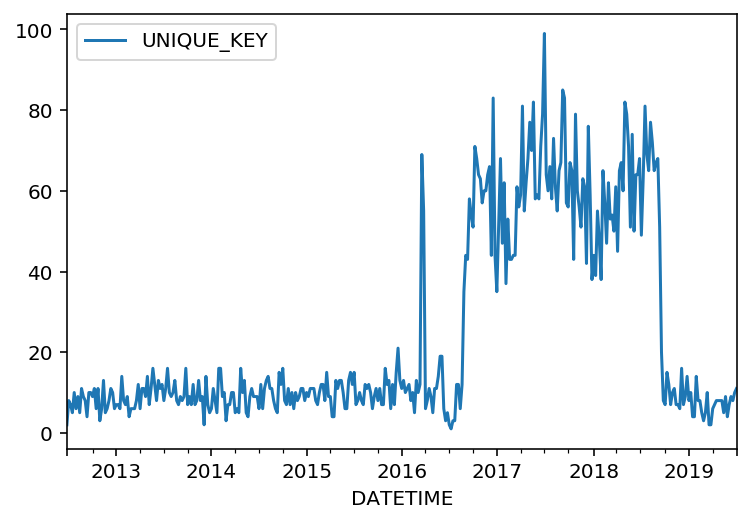

In [111]:
nm2.pivot_table(
    index='DATETIME',
    values='UNIQUE_KEY',
    aggfunc='count'
).resample('1W').sum().plot()

In [112]:
nm2['ON_STREET_NAME'].value_counts().head(10)

VERRAZANO BRIDGE UPPER              859
BRONX WHITESTONE BRIDGE             774
BROOKLYN BRIDGE                     606
VERRAZANO BRIDGE LOWER              355
THROGS NECK BRIDGE                  344
WILLIAMSBURG BRIDGE OUTER ROADWA    316
BROOKLYN BATTERY TUNNEL             311
QUEENS MIDTOWN TUNNEL               310
ROCKAWAY BOULEVARD                  264
TRIBOROUGH BRIDGE                   222
Name: ON_STREET_NAME, dtype: int64

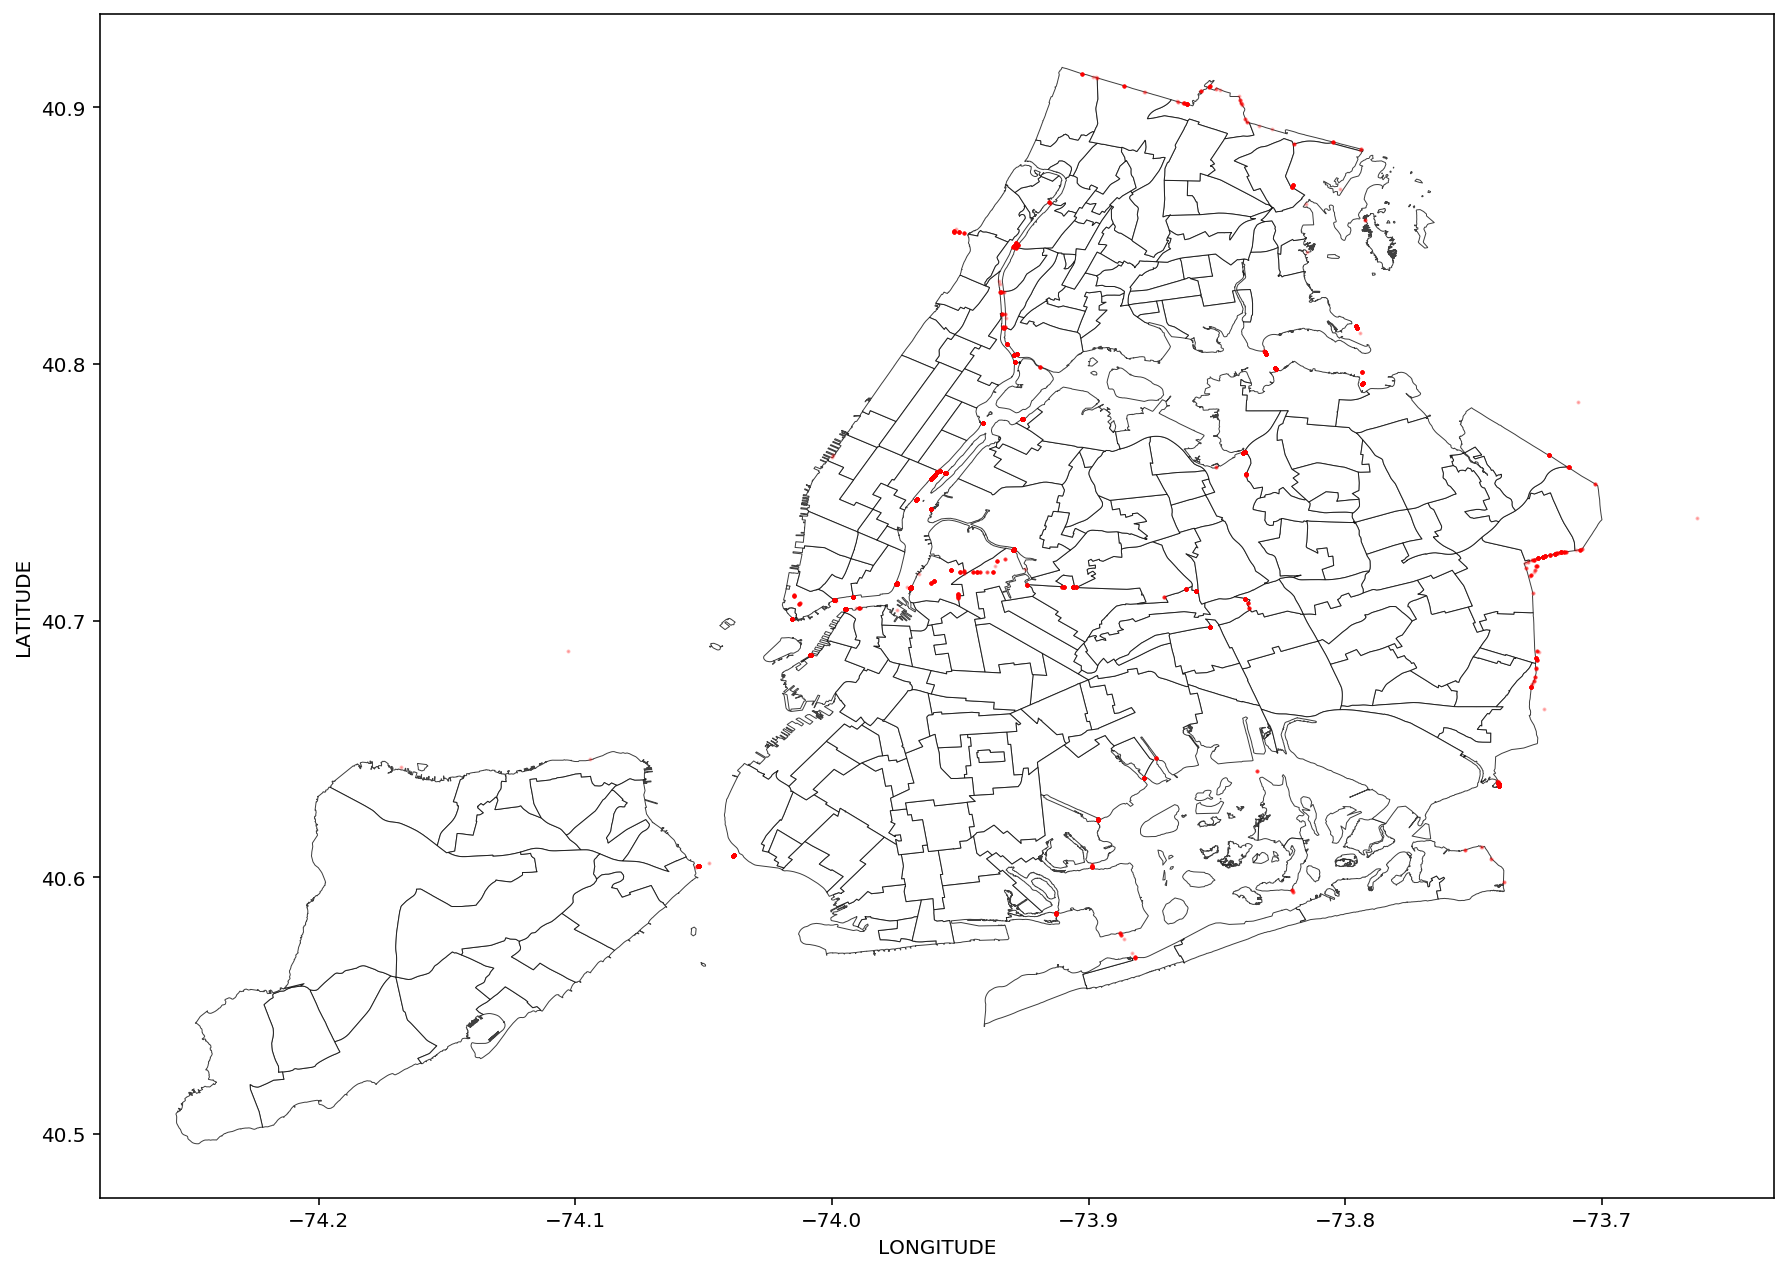

In [113]:
# The plot reveals that these are all bridge accidents
#
# Perhaps we may want to keep them in later versions
#
base = df_nyc.plot(
    linewidth=0.5,
    color='White',
    edgecolor='Black',
    figsize=(15, 12),
    alpha=0.75)

df[ df['UNIQUE_KEY'].isin(not_matching) & mask ].plot(
    kind='scatter',
    x='LONGITUDE',
    y='LATITUDE',
    figsize=(15, 12),
    c='red',
    s=1,
    alpha=0.25, ax=base)

In [114]:
# Code below lists cases where the borough is incorrectly coded based on lon/lat
# TODO: Perhaps also check cases where zipcode is incorrectly coded
errors = gdf [ ~gdf.BOROUGH.isnull() & (gdf.GEO_BOROUGH.str.lower() != gdf.BOROUGH.str.lower()) ]
errors = pd.DataFrame(errors)

In [115]:
len(errors)

1776

In [116]:
errors.LOCATION.value_counts().head(10)

(40.7136, -74.0091)                  92
(40.8756831, -73.9083783)            58
(40.7244, -73.9818)                  51
(40.7339, -73.9542)                  46
(40.699937799999994, -73.9118079)    38
(40.873642, -73.90796999999999)      36
(40.8772207, -73.90904509999999)     32
(40.875640000000004, -73.90836)      28
(40.699531, -73.91103670000001)      28
(40.7086946, -73.92070179999999)     18
Name: LOCATION, dtype: int64

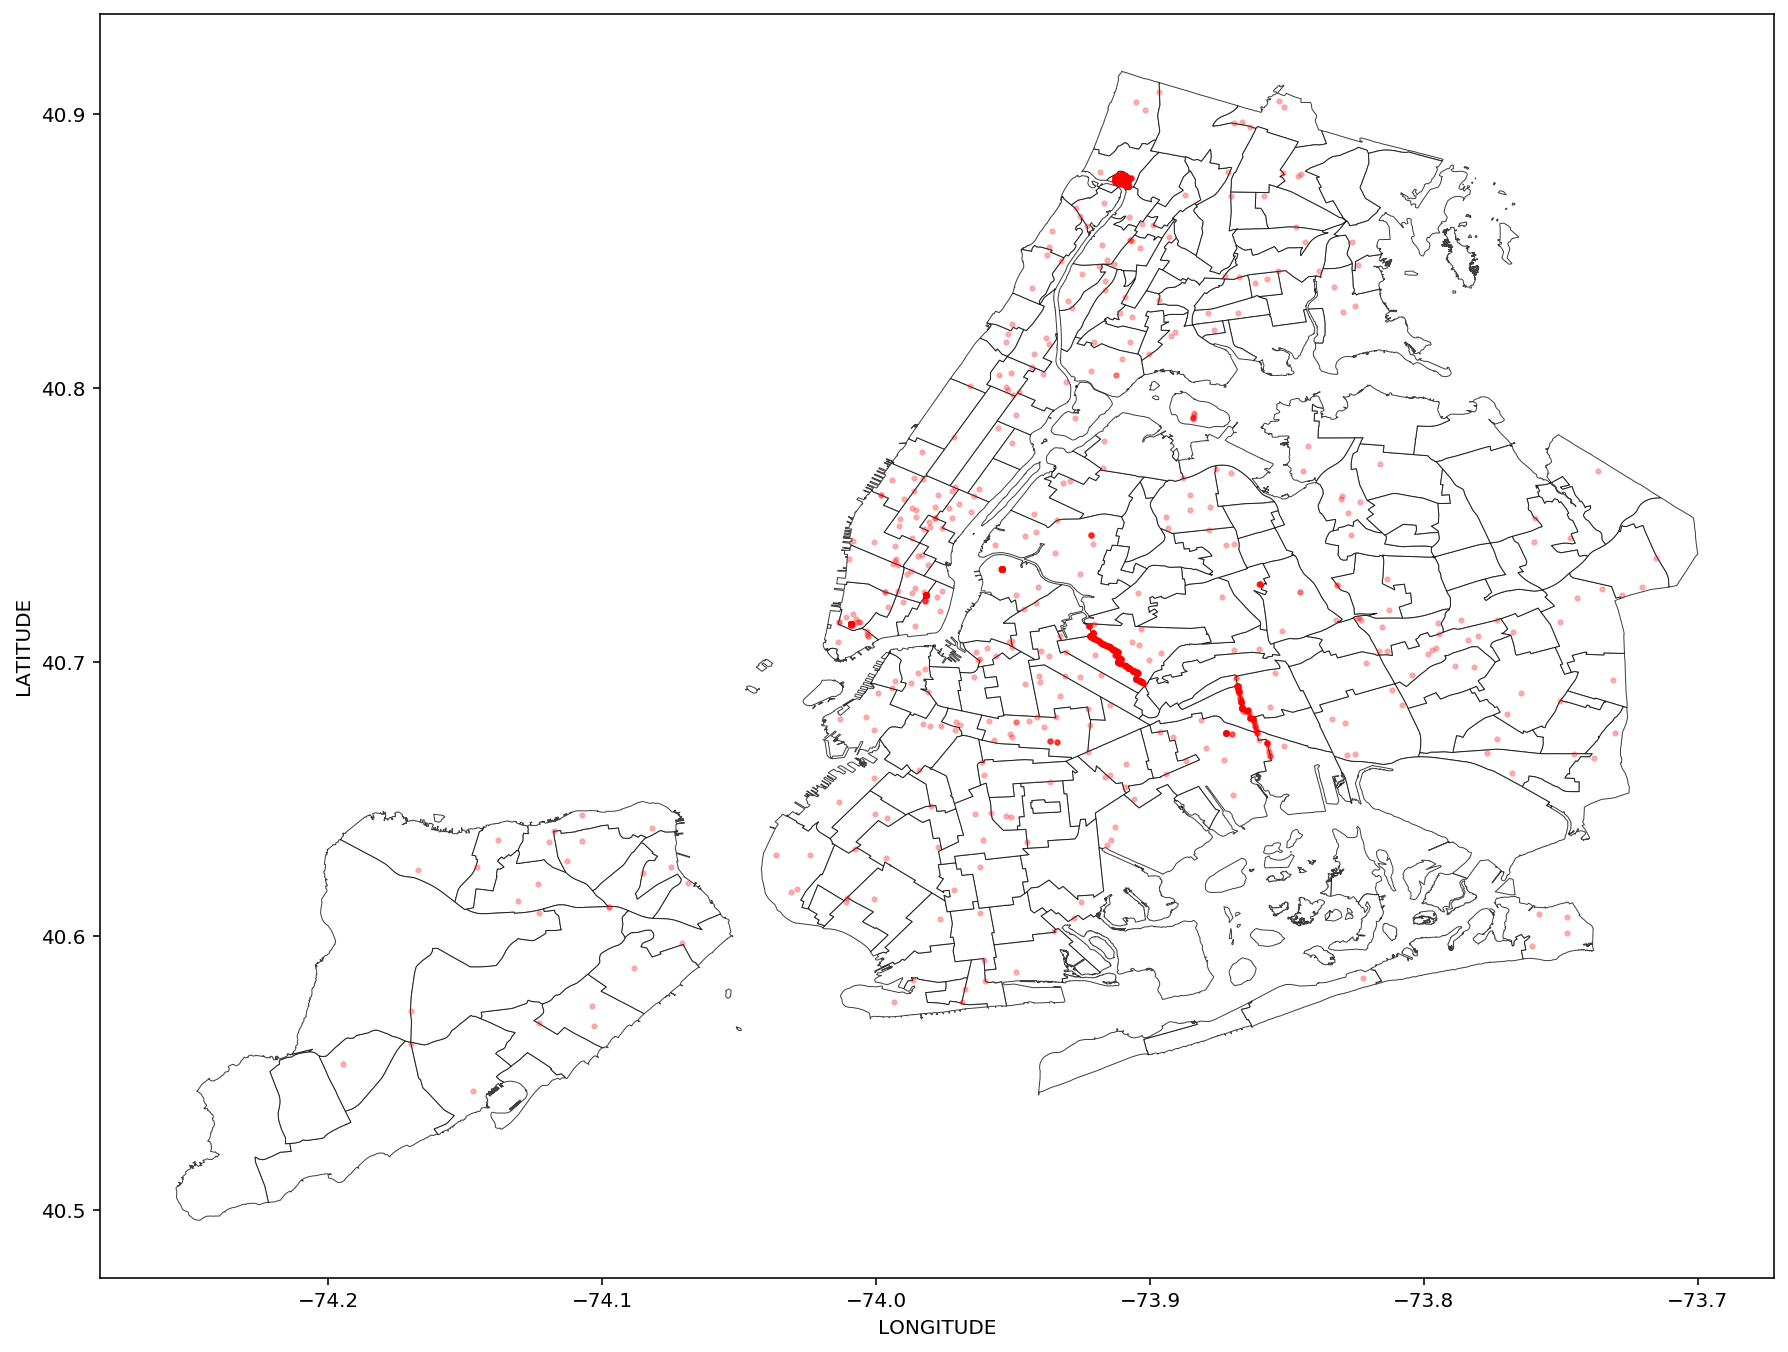

In [117]:
# The plot reveals that most are border issues
# but there are random errors spread throughout the city
base = df_nyc.plot(
    linewidth=0.5,
    color='White',
    edgecolor='Black',
    figsize=(15, 15),
    alpha=0.75)

errors.plot(
    kind='scatter',
    x='LONGITUDE',
    y='LATITUDE',
    figsize=(15, 12),
    c='red',
    s=5,
    alpha=0.25, ax=base)

In [118]:
# Code below lists cases where the borough is incorrectly coded based on lon/lat
errors_zip = gdf [ ~gdf.ZIPCODE.isnull() & ~gdf.GEO_ZIPCODE.isnull() & (gdf.GEO_ZIPCODE != gdf.ZIPCODE) ]
errors_zip = pd.DataFrame(errors_zip)
len(errors_zip)

88379

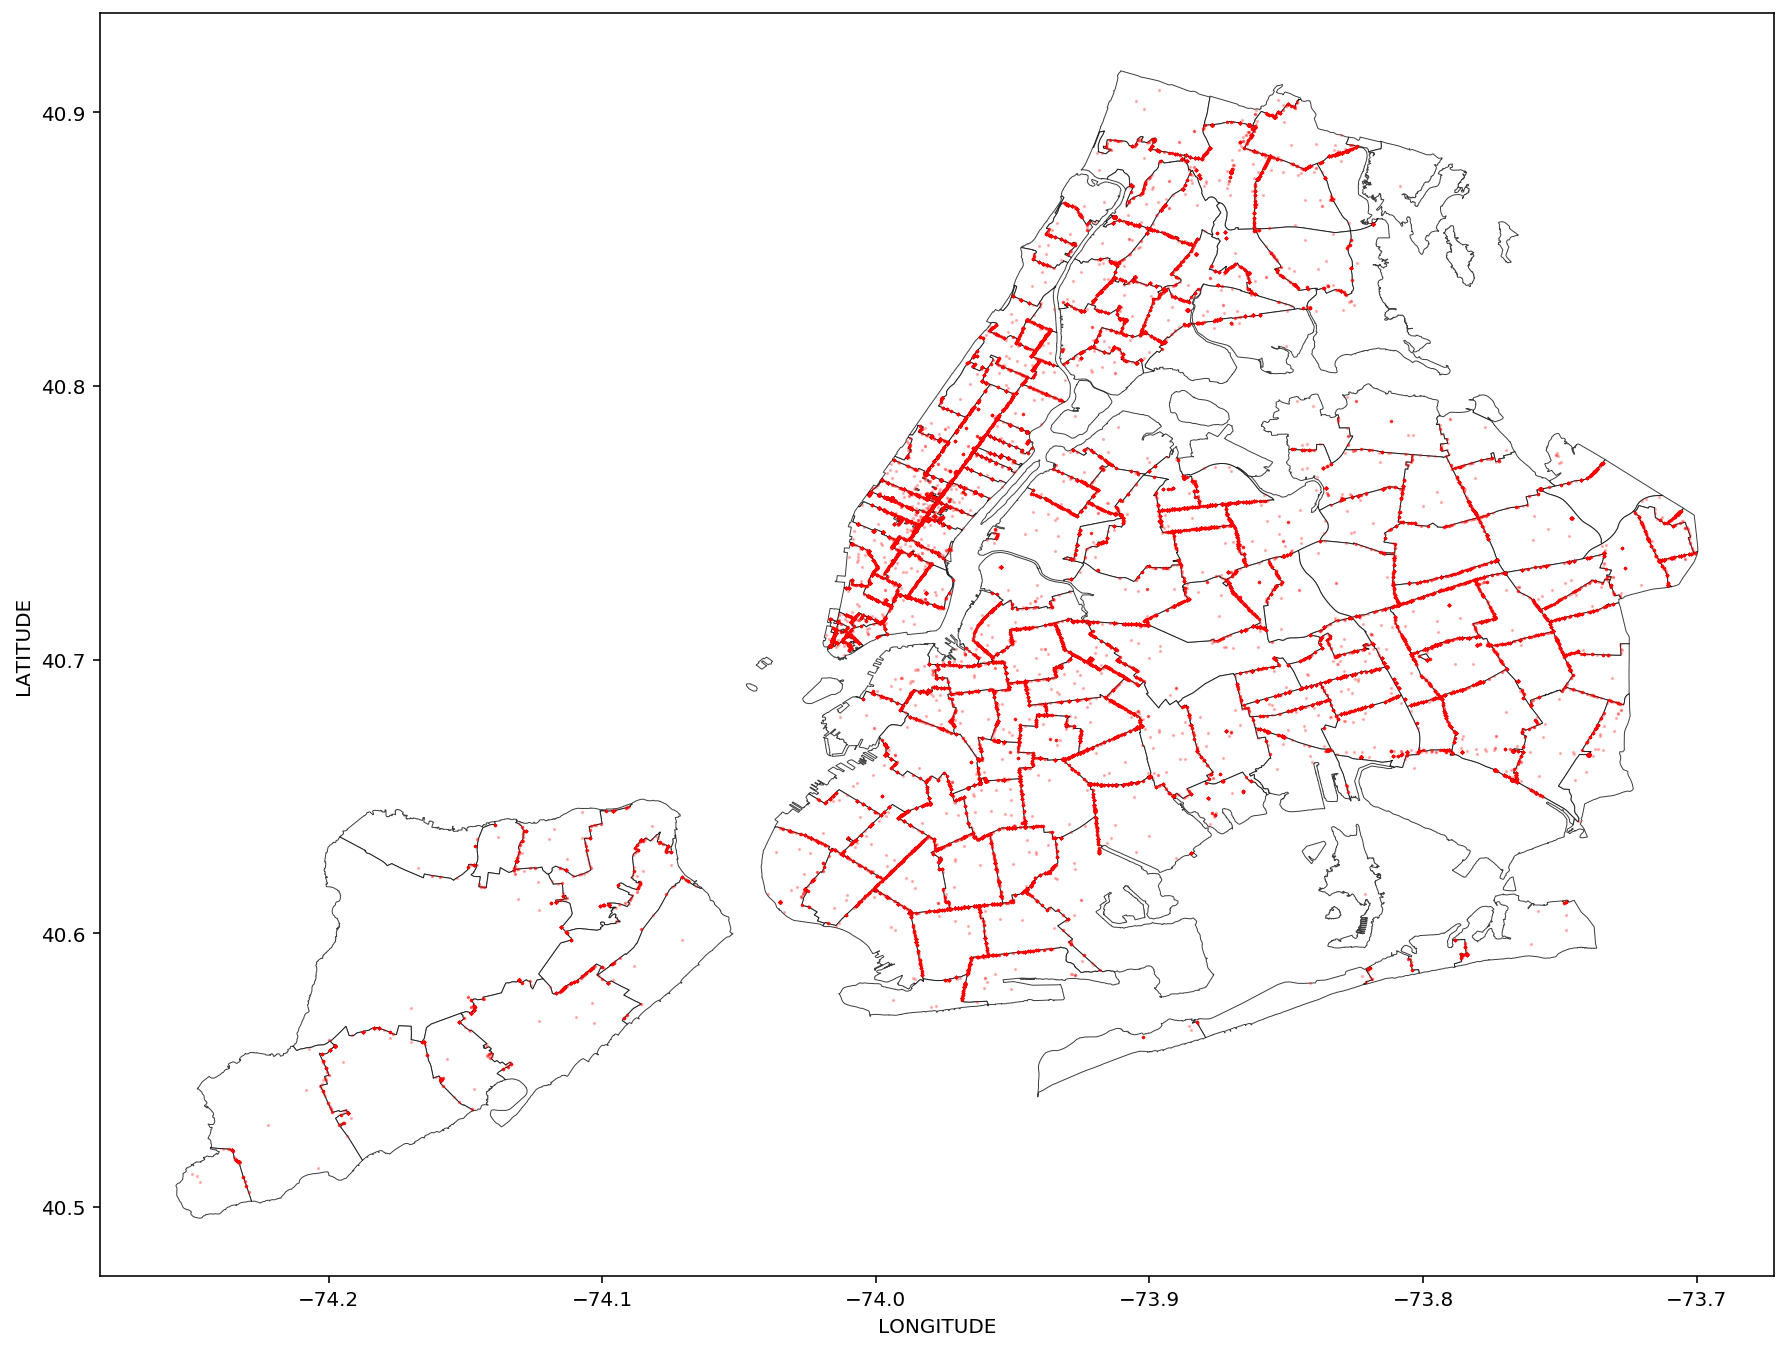

In [119]:
# The plot reveals that most are border issues
# but there are random errors spread throughout the city
base = df_zip.plot(
    linewidth=0.5,
    color='White',
    edgecolor='Black',
    figsize=(15, 15),
    alpha=0.75)

errors_zip.plot(
    kind='scatter',
    x='LONGITUDE',
    y='LATITUDE',
    figsize=(15, 12),
    c='red',
    s=0.5,
    alpha=0.25, ax=base)

In [120]:
gdf = gdf.drop(['ZIPCODE', 'BOROUGH'], axis='columns')


In [121]:
gdf = gdf.rename({
    'GEO_ZIPCODE': 'ZIPCODE',
    'GEO_BOROUGH': 'BOROUGH',
    'GEO_NEIGHBORHOOD': 'NEIGHBORHOOD'
}, axis='columns')

In [122]:
# Reorder the columns

columns = [
    'UNIQUE_KEY', 'DATETIME', 'LATITUDE', 'LONGITUDE', 'ON_STREET_NAME',
    'CROSS_STREET_NAME', 'OFF_STREET_NAME', 'ZIPCODE', 'NEIGHBORHOOD',
    'BOROUGH', 'PERSONS_INJURED', 'PERSONS_KILLED', 'PEDESTRIANS_INJURED',
    'PEDESTRIANS_KILLED', 'CYCLISTS_INJURED', 'CYCLISTS_KILLED',
    'MOTORISTS_INJURED', 'MOTORISTS_INJURED'
]

gdf = gdf[columns]

In [123]:
# Sort by date
gdf = gdf.sort_values('DATETIME')

In [124]:
final_df = pd.DataFrame(gdf)

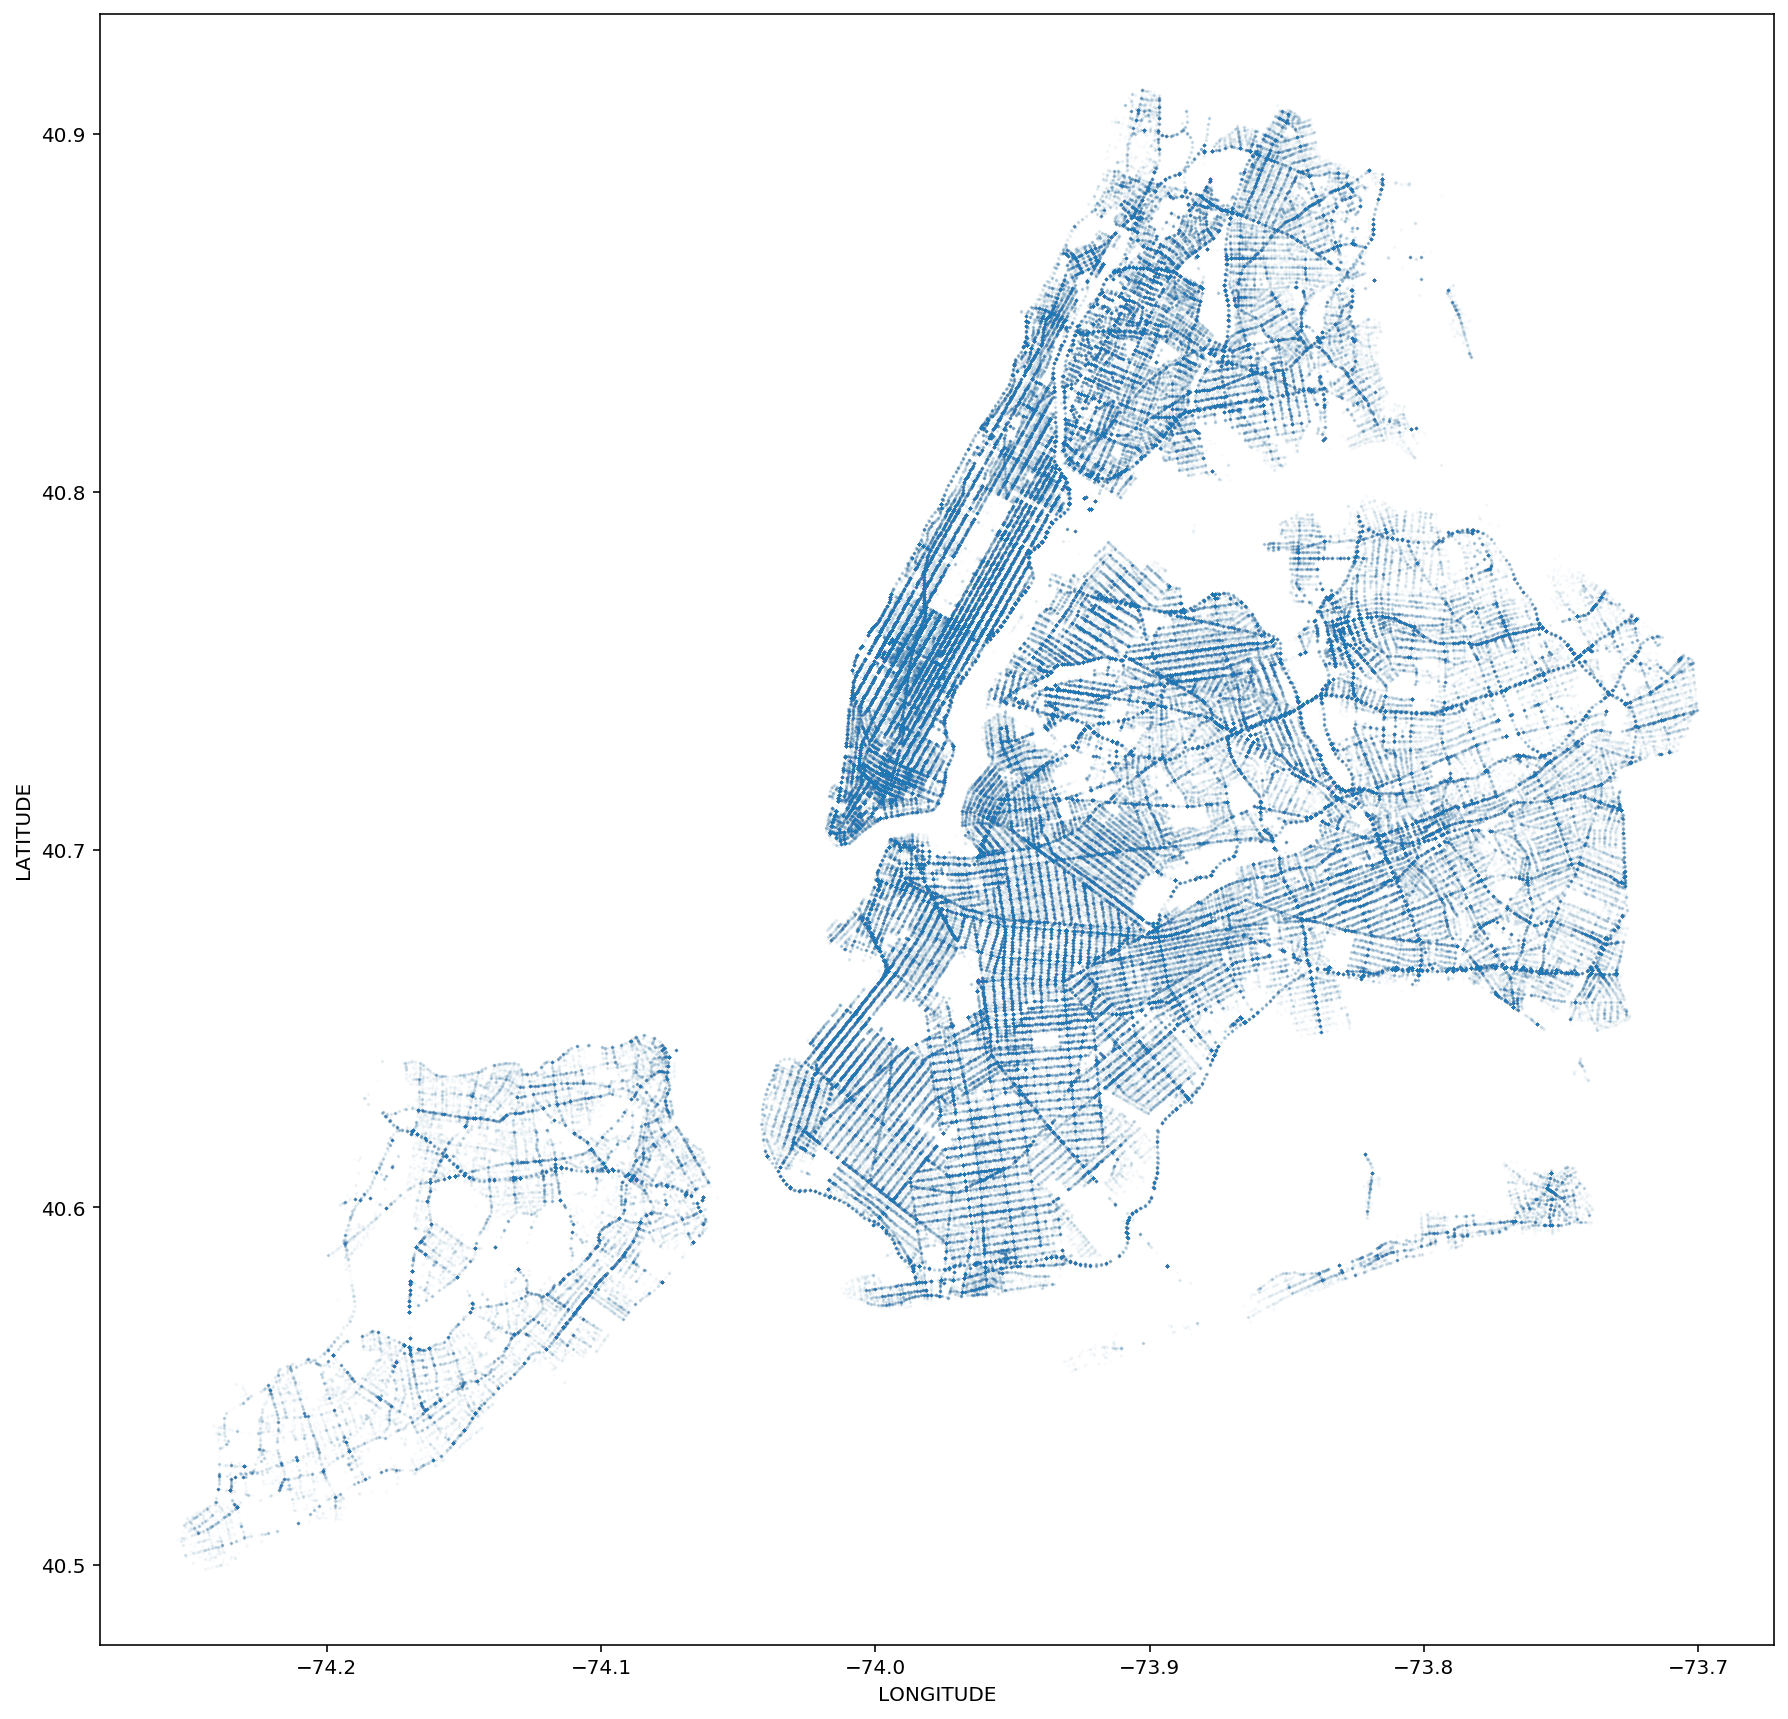

In [125]:
final_df.plot.scatter(x='LONGITUDE', y='LATITUDE',figsize=(15,15), s=0.5, alpha=0.02)

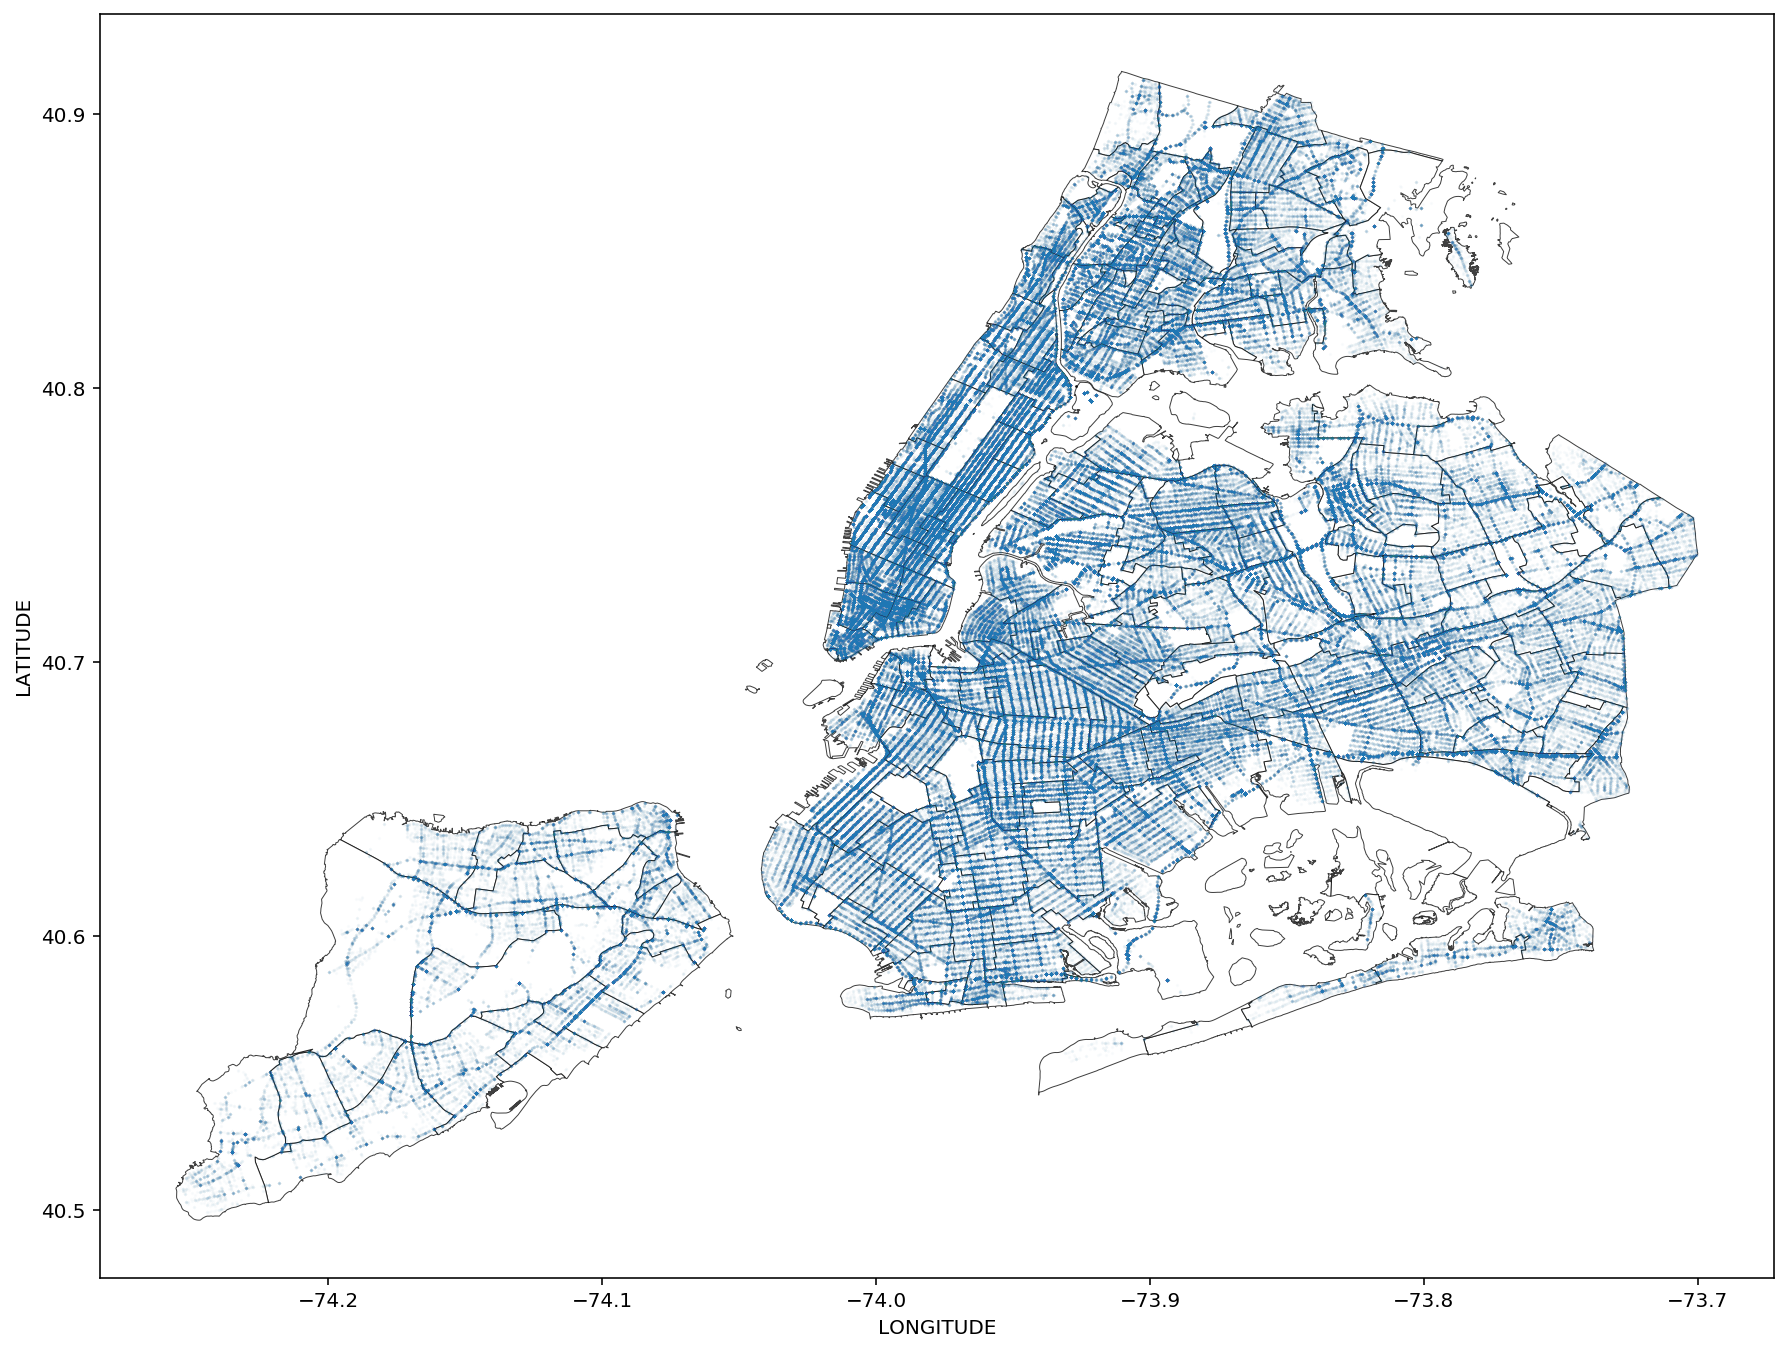

In [126]:
base = df_nyc.plot(
    linewidth=0.5,
    color='White',
    edgecolor='Black',
    figsize=(15, 15),
    alpha=0.75)

scatterplot = final_df.plot(
    kind='scatter',
    x='LONGITUDE',
    y='LATITUDE',
    s=0.5,
    alpha=0.02,
    ax=base)

In [127]:
final_df.to_csv('collisions.csv.gz', index=False, compression='gzip')

In [213]:
za = pd.DataFrame(final_df.ZIPCODE.value_counts())
za.columns=['ACCIDENTS']
za = za.merge(df_zip,left_index=True,right_on='ZIPCODE',how='right')
za['NORM_ACC'] = -np.log10(za.ACCIDENTS/za.AREA)


In [214]:
gza = gpd.GeoDataFrame(za, geometry='geometry')
gza.sort_values('NORM_ACC').head(1)

ACCIDENTS ZIPCODE BLDGZIP   PO_NAME  POPULATION           AREA STATE  \
123     7273.0   11231       0  Brooklyn     33144.0  701979.385312    NY   

    COUNTY ST_FIPS CTY_FIPS                   URL  SHAPE_AREA  SHAPE_LEN  \
123  Kings      36      047  http://www.usps.com/         0.0        0.0   

                                              geometry  NORM_ACC  
123  POLYGON ((-74.01657954588148 40.66476193805086...  1.984611

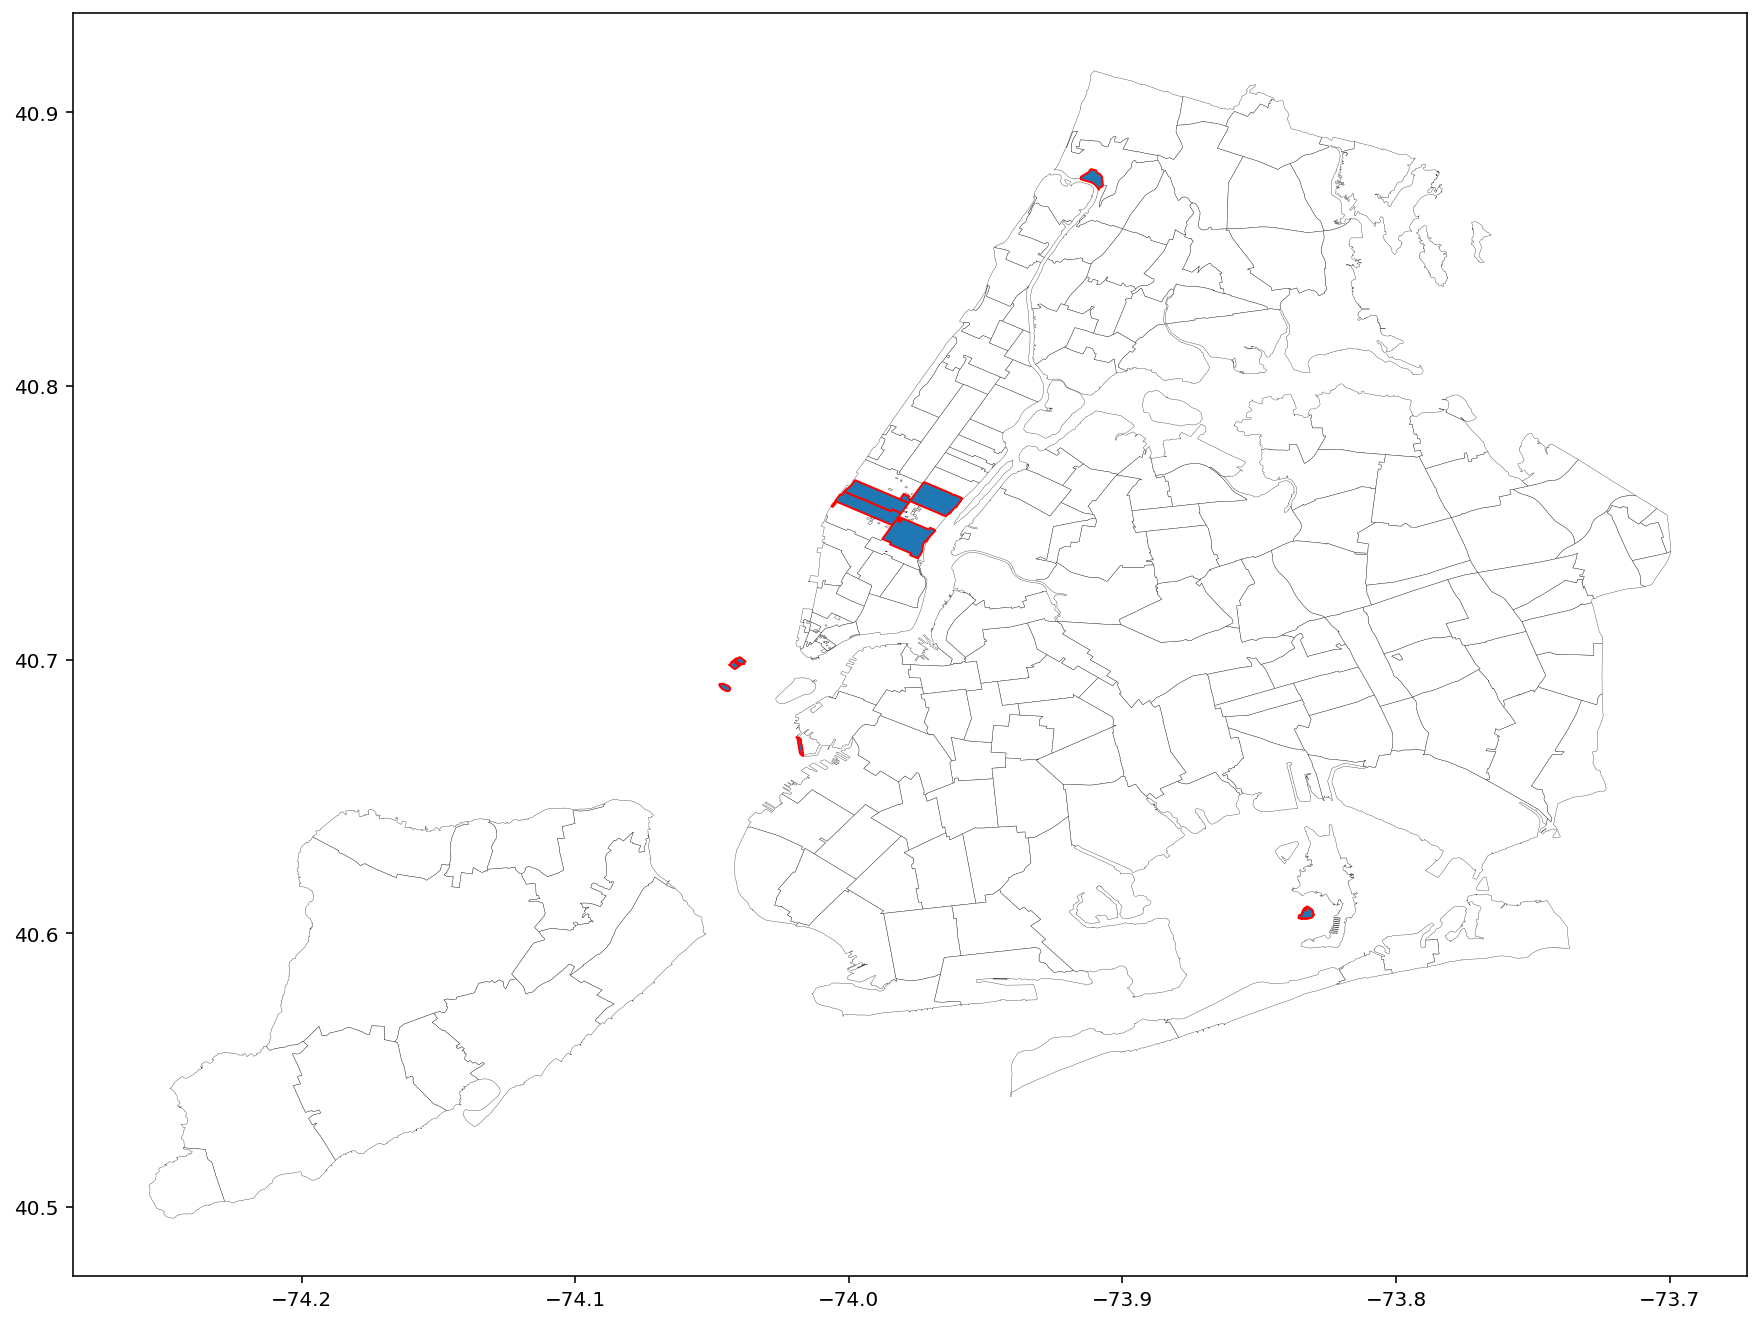

In [216]:
b = df_zip.plot(
    linewidth=0.2,
    color='White',
    edgecolor='Black',
    figsize=(15, 15),
    alpha=0.75)

gza.sort_values('NORM_ACC').head(10).plot(linewidth=1, edgecolor='Red', ax =b )

/usr/local/lib/python3.6/dist-packages/mapclassify/classifiers.py:320: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/usr/local/lib/python3.6/dist-packages/mapclassify/classifiers.py:320: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


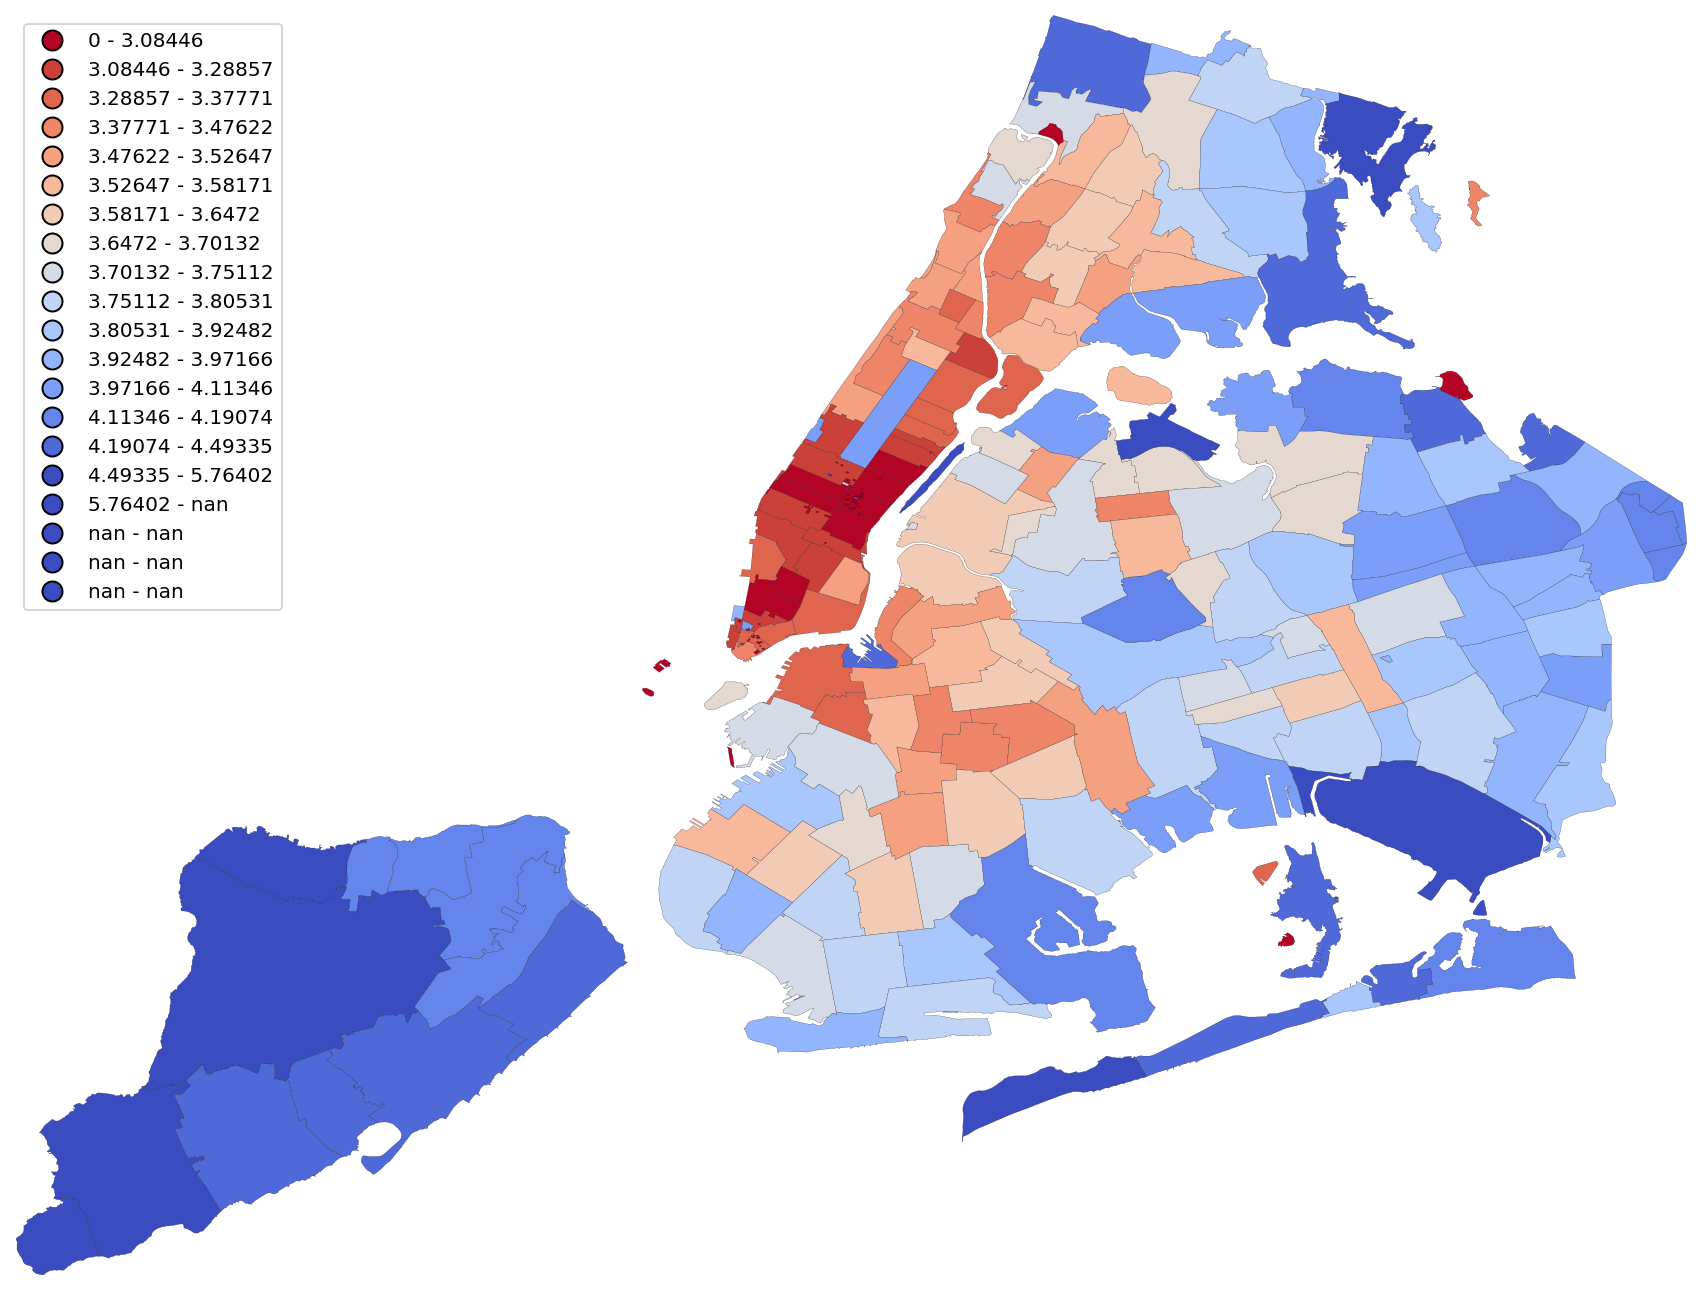

In [217]:
import geoplot
import geoplot.crs as gcrs



geoplot.choropleth(gza,
                   hue='NORM_ACC',
                   linewidth=0.1,
                   edgecolor='Black',
                   figsize=(15, 15),
                   cmap='coolwarm_r',
                   scheme='quantiles',
                   k=20,
                   legend=True,
                   legend_kwargs={
                       'loc': 'upper left'
                   })

## TODO

* Examine the contents of Contributing factor and Vehicle type. Replace noisy values with UNSPECIFIED
* 
* Normalize Contributing factor and Vehicle type, and split results in a separate table. Create MySQL/SQLite database with proper normalization.

* Add a column "NUM_VEHICLES" to show the number of vehicles involved in the accident. Check that we do not have NaNs before a real value in CAUSE and in VEHICLE TYPE, and that the two columns (CAUSE AND VEHICLE) agree in the number.

In [128]:
fdf = final_df.set_index("UNIQUE_KEY")

In [129]:
cols = [fdf.CAUSE_VEHICLE_1, fdf.CAUSE_VEHICLE_2, fdf.CAUSE_VEHICLE_3, fdf.CAUSE_VEHICLE_4, fdf.CAUSE_VEHICLE_5]
causes = pd.concat( cols ).dropna()

AttributeError: 'DataFrame' object has no attribute 'CAUSE_VEHICLE_1'

In [ ]:
# We replace noisy causes with UNSPECIFIED and not with NaN, as NaN is used to mean "no vehicle"
import numpy as np
causes = causes.replace(to_replace='1', value='UNSPECIFIED')
causes = causes.replace(to_replace='80', value='UNSPECIFIED')
causes = causes.replace(to_replace='ILLNES', value='ILLNESS')

In [ ]:
causes.value_counts()#.sort_index()

In [ ]:
cols = [fdf.TYPE_VEHICLE_1, fdf.TYPE_VEHICLE_2, fdf.TYPE_VEHICLE_3, fdf.TYPE_VEHICLE_4, fdf.TYPE_VEHICLE_5]

# cols = [fdf.TYPE_VEHICLE_4] # , fdf.TYPE_VEHICLE_2, fdf.TYPE_VEHICLE_3, fdf.TYPE_VEHICLE_4, fdf.TYPE_VEHICLE_5]

types = pd.concat( cols ).dropna()


In [ ]:
types.value_counts()[20:]

In [ ]:
# Also consult https://data.ny.gov/api/assets/83055271-29A6-4ED4-9374-E159F30DB5AE

types = types.replace(to_replace='STATION WAGON/SPORT UTILITY VEHICLE', value='SPORT UTILITY / STATION WAGON')
types = types.replace(to_replace='SUBN', value='SPORT UTILITY / STATION WAGON')
types = types.replace(to_replace='SUBN/', value='SPORT UTILITY / STATION WAGON')

types = types.replace(to_replace='WAGON', value='SPORT UTILITY / STATION WAGON')

types = types.replace(to_replace='BU', value='BUS')
types = types.replace(to_replace='BS', value='BUS')
types = types.replace(to_replace='SCHOOL BUS', value='BUS')

types = types.replace(to_replace='P/SH', value='POWER SHOVEL')



types = types.replace(to_replace='MULTI-WHEELED VEHICLE', value='LARGE COM VEH(6 OR MORE TIRES)')
types = types.replace(to_replace='SMALL', value='SMALL COM VEH(4 TIRES)')
types = types.replace(to_replace='SMALL COM VEH(4 TIRES) ', value='SMALL COM VEH(4 TIRES)')

types = types.replace(to_replace='LIVER', value='LIVERY VEHICLE')
types = types.replace(to_replace='LIMOU', value='LIVERY VEHICLE')
types = types.replace(to_replace='LIMO', value='LIVERY VEHICLE')
types = types.replace(to_replace='LIMO/', value='LIVERY VEHICLE')

types = types.replace(to_replace='FORKL', value='FORK LIFT')
types = types.replace(to_replace='FORK', value='FORK LIFT')

types = types.replace(to_replace='DUMPS', value='DUMP')
types = types.replace(to_replace='DUMPT', value='DUMP')
types = types.replace(to_replace='PUMP', value='DUMP')
types = types.replace(to_replace='DP', value='DUMP')
types = types.replace(to_replace='DUMP', value='GARBAGE OR REFUSE')
types = types.replace(to_replace='GARBA', value='GARBAGE OR REFUSE')


types = types.replace(to_replace='CONV', value='CONVERTIBLE')
types = types.replace(to_replace='CONVE', value='CONVERTIBLE')

types = types.replace(to_replace='SP', value='SNOW PLOW')

types = types.replace(to_replace='2 DR SEDAN', value='SEDAN')
types = types.replace(to_replace='4 DR SEDAN', value='SEDAN')
types = types.replace(to_replace='SUDAN', value='SEDAN')
types = types.replace(to_replace='SE', value='SEDAN')
types = types.replace(to_replace='4DS', value='SEDAN')
types = types.replace(to_replace='4DSD', value='SEDAN')
types = types.replace(to_replace='3-DOOR', value='SEDAN')


types = types.replace(to_replace='VAN CAMPER', value='VAN')
types = types.replace(to_replace='VAN T', value='VAN')
types = types.replace(to_replace='VAN F', value='VAN')
types = types.replace(to_replace='VAN A', value='VAN')
types = types.replace(to_replace='VAN W', value='VAN')
types = types.replace(to_replace='VAN/B', value='VAN')
types = types.replace(to_replace='VAB', value='VAN')
types = types.replace(to_replace='VAN C', value='VAN')
types = types.replace(to_replace='VAN/T', value='VAN')
types = types.replace(to_replace='VANETTE', value='VAN')
types = types.replace(to_replace='VAN`', value='VAN')
types = types.replace(to_replace='VAV', value='VAN')
types = types.replace(to_replace='VN', value='VAN')
types = types.replace(to_replace='VAN (', value='VAN')
types = types.replace(to_replace='ENCLOSED BODY - REMOVABLE ENCLOSURE', value='VAN')
types = types.replace(to_replace='ENCLOSED BODY - NONREMOVABLE ENCLOSURE', value='VAN')
types = types.replace(to_replace='ENCLO', value='VAN')


types = types.replace(to_replace='MOTOR HOME', value='R/V')
types = types.replace(to_replace='MOTORIZED HOME', value='R/V')
types = types.replace(to_replace='RV', value='R/V')
types = types.replace(to_replace='R/V C', value='R/V')
types = types.replace(to_replace='RV/TR', value='R/V')
types = types.replace(to_replace='H/WH', value='R/V') # house on wheels


types = types.replace(to_replace='AM', value='AMBULANCE')
types = types.replace(to_replace='AMB', value='AMBULANCE')
types = types.replace(to_replace='AMBU', value='AMBULANCE')
types = types.replace(to_replace='AMBUL', value='AMBULANCE')
types = types.replace(to_replace='ANBUL', value='AMBULANCE')
types = types.replace(to_replace='AMABU', value='AMBULANCE')
types = types.replace(to_replace='AMULA', value='AMBULANCE')
types = types.replace(to_replace='ABULA', value='AMBULANCE')

types = types.replace(to_replace='BICYC', value='BICYCLE')
types = types.replace(to_replace='BIKE', value='BICYCLE')

types = types.replace(to_replace='TANK', value='TANK TRUCK')
types = types.replace(to_replace='TANKE', value='TANK TRUCK')
types = types.replace(to_replace='TANKER', value='TANK TRUCK')

types = types.replace(to_replace='OTHER', value='UNKNOWN')
types = types.replace(to_replace='UNK', value='UNKNOWN')
types = types.replace(to_replace='UNK,', value='UNKNOWN')
types = types.replace(to_replace='UNKN', value='UNKNOWN')
types = types.replace(to_replace='UNKNO', value='UNKNOWN')
types = types.replace(to_replace='UNKNOWN', value='UNKNOWN')
types = types.replace(to_replace='UNKOW', value='UNKNOWN')
types = types.replace(to_replace='UNNKO', value='UNKNOWN')

types = types.replace(to_replace='SCOO', value='SCOOTER')
types = types.replace(to_replace='SCOOT', value='SCOOTER')
types = types.replace(to_replace='MOTER', value='SCOOTER')
types = types.replace(to_replace='MOPD', value='SCOOTER')
types = types.replace(to_replace='MOPAD', value='SCOOTER')
types = types.replace(to_replace='MOPET', value='SCOOTER')
types = types.replace(to_replace='MOPEN', value='SCOOTER')
types = types.replace(to_replace='E BIK', value='SCOOTER')
types = types.replace(to_replace='E-BIK', value='SCOOTER')
types = types.replace(to_replace='E/BIK', value='SCOOTER')
types = types.replace(to_replace='MINIBIKE', value='SCOOTER')
types = types.replace(to_replace='MOPED', value='SCOOTER')



types = types.replace(to_replace='US PO', value='USPS')
types = types.replace(to_replace='USPOS', value='USPS')
types = types.replace(to_replace='USPS2', value='USPS')
types = types.replace(to_replace='USPST', value='USPS')
types = types.replace(to_replace='U.S P', value='USPS')
types = types.replace(to_replace='U.S.', value='USPS')

types = types.replace(to_replace='COMME', value='COMMERCIAL')
types = types.replace(to_replace='COM', value='COMMERCIAL')
types = types.replace(to_replace='COMM', value='COMMERCIAL')
types = types.replace(to_replace='COM T', value='COMMERCIAL')
types = types.replace(to_replace='COM.', value='COMMERCIAL')
types = types.replace(to_replace='COMMM', value='COMMERCIAL')
types = types.replace(to_replace='COMER', value='COMMERCIAL')
types = types.replace(to_replace='COMMM', value='COMMERCIAL')
types = types.replace(to_replace='COM.', value='COMMERCIAL')
types = types.replace(to_replace='COMIX', value='COMMERCIAL')
types = types.replace(to_replace='COMPA', value='COMMERCIAL')
types = types.replace(to_replace='COMB', value='COMMERCIAL')
types = types.replace(to_replace='COMMU', value='COMMERCIAL')
types = types.replace(to_replace='COMM.', value='COMMERCIAL')
types = types.replace(to_replace='C0MME', value='COMMERCIAL')

types = types.replace(to_replace='PASS', value='PASSENGER VEHICLE')
types = types.replace(to_replace='PAS', value='PASSENGER VEHICLE')
types = types.replace(to_replace='PASSE', value='PASSENGER VEHICLE')



types = types.replace(to_replace='PEDIC', value='PEDICAB')

types = types.replace(to_replace='TOW T', value='TOW TRUCK / WRECKER')
types = types.replace(to_replace='TOW', value='TOW TRUCK / WRECKER')
types = types.replace(to_replace='TOW TRUCK', value='TOW TRUCK / WRECKER')
types = types.replace(to_replace='TOWTR', value='TOW TRUCK / WRECKER')
types = types.replace(to_replace='TOW-T', value='TOW TRUCK / WRECKER')
types = types.replace(to_replace='TOWIN', value='TOW TRUCK / WRECKER')
types = types.replace(to_replace='TOWER', value='TOW TRUCK / WRECKER')
types = types.replace(to_replace='G TOW', value='TOW TRUCK / WRECKER')



types = types.replace(to_replace='TKP', value='PICK-UP TRUCK')
types = types.replace(to_replace='PK', value='PICK-UP TRUCK')
types = types.replace(to_replace='PICK', value='PICK-UP TRUCK')
types = types.replace(to_replace='PICK-', value='PICK-UP TRUCK')
types = types.replace(to_replace='PICKU', value='PICK-UP TRUCK')
types = types.replace(to_replace='PICKUP WITH MOUNTED CAMPER', value='PICK-UP TRUCK')

types = types.replace(to_replace='FLAT BED', value='PICK-UP TRUCK')
types = types.replace(to_replace='FLAT RACK', value='PICK-UP TRUCK')
types = types.replace(to_replace='FLATB', value='PICK-UP TRUCK')
types = types.replace(to_replace='FLAT', value='PICK-UP TRUCK')
types = types.replace(to_replace='FLAT RACK', value='PICK-UP TRUCK')
types = types.replace(to_replace='FLATB', value='PICK-UP TRUCK')
types = types.replace(to_replace='BACK', value='PICK-UP TRUCK')

types = types.replace(to_replace='FDNY', value='FIRE TRUCK')
types = types.replace(to_replace='FIRE', value='FIRE TRUCK')
types = types.replace(to_replace='FIRET', value='FIRE TRUCK')
types = types.replace(to_replace='FD NY', value='FIRE TRUCK')
types = types.replace(to_replace='FD TR', value='FIRE TRUCK')
 

    

types = types.replace(to_replace='TRACTOR TRUCK DIESEL', value='TRACTOR TRUCK')
types = types.replace(to_replace='TRACTOR TRUCK GASOLINE', value='TRACTOR TRUCK')
types = types.replace(to_replace='TRAC.', value='TRACTOR TRUCK')
types = types.replace(to_replace='TRAC', value='TRACTOR TRUCK')


types = types.replace(to_replace='TRAIL', value='TRAILER')
types = types.replace(to_replace='TR', value='TRAILER')
types = types.replace(to_replace='TRL', value='TRAILER')
types = types.replace(to_replace='TRAIL', value='TRAILER')
types = types.replace(to_replace='TRLR', value='TRAILER')


types = types.replace(to_replace='SEMI', value='TRUCK')
types = types.replace(to_replace='SEMI-', value='TRUCK')

types = types.replace(to_replace='MACK', value='TRUCK')
types = types.replace(to_replace='TK', value='TRUCK')
types = types.replace(to_replace='TRACT', value='TRUCK')
types = types.replace(to_replace='TRK', value='TRUCK')
types = types.replace(to_replace='TRACK', value='TRUCK')


types = types.replace(to_replace='FB', value='BOX TRUCK')
types = types.replace(to_replace='BOX T', value='BOX TRUCK')
types = types.replace(to_replace='BOX', value='BOX TRUCK')
types = types.replace(to_replace='BOXTR', value='BOX TRUCK')


types = types.replace(to_replace='MOTOR', value='MOTORCYCLE')
types = types.replace(to_replace='MINICYCLE', value='MOTORCYCLE')
types = types.replace(to_replace='MOTORBIKE', value='MOTORCYCLE')

types = types.replace(to_replace='DSNY', value='SANITATION')
types = types.replace(to_replace='DS', value='SANITATION')

types = types.replace(to_replace='SANIT', value='SANITATION')

types = types.replace(to_replace='DELV', value='DELIVERY TRUCK')
types = types.replace(to_replace='DEL', value='DELIVERY TRUCK')

types = types.replace(to_replace='RD/S', value='ROAD SWEEPER')
types = types.replace(to_replace='OML/', value='LIVERY VEHICLE') # OMNIBUS LIVERY


'S/SP', 'E/BIK', 'TR/KI', 'ME/BE', 'GE/SC'



In [ ]:
import ngram
import math
freq = types.value_counts()
vtypes = types.value_counts().index.values

similarities = []
for t1 in vtypes:
    for t2 in vtypes:
        s = ngram.NGram.compare(t1, t2, n=2)
        f1 = freq.loc[t1]
        f2 = freq.loc[t2]
        r = abs(math.log10(f1/f2))
        f = f1 + f2
        if f2 > f1:
            fr1 = f2
            fr2 = f1
            tp1 = t2
            tp2 = t1
        else:
            fr1 = f1
            fr2 = f2
            tp1 = t1
            tp2 = t2
            
        sim = {
            "t1" : tp1,
            "f1" : fr1,
            "t2" : tp2,
            "f2" : fr2,
            "sim" : s,
            "ratio" : r
        }
            
        if t1>t2 and s>0.1 and f > 1000 and r>1.5 and min(f1,f2)<200:
            similarities.append(sim)

pd.DataFrame(similarities).sort_values('sim', ascending=False)

In [ ]:
types.value_counts()[ types.value_counts().index.str.contains("/") ].index.values

In [ ]:
(types.value_counts().sum() - types.value_counts().cumsum()).plot(logy=True)

In [ ]:
replace = types.value_counts() [ types.value_counts() <= 10]
for r in replace.index.values:
    types = types.replace(to_replace=r, value='UNKNOWN')


In [ ]:
# 4050018: Panos :-)
final_df.set_index('UNIQUE_KEY').loc['4050018']